In [1]:
#Function to generate a 3-panel plot for input arrays
def plot_array(dem, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(titles[0])
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [ax.imshow(dem, clim=clim, cmap=cmap, alpha=alpha)]
    fig.tight_layout()
    fig.colorbar(im_list[0], label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)

#Function to generate a 3-panel plot for input arrays
def plot2panel(dem_list, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, axa = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    for n, ax in enumerate(axa):
        #Gray background
        ax.set_facecolor('0.5')
        #Force aspect ratio to match images
        ax.set(aspect='equal')
        #Turn off axes labels/ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(titles[n])
        #Plot background shaded relief map
        if overlay is not None:
            alpha = 0.7
            axa[n].imshow(overlay[n], cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [axa[i].imshow(dem_list[i], clim=clim, cmap=cmap, alpha=alpha) for i in range(len(dem_list))]
    fig.tight_layout()
    fig.colorbar(im_list[0], ax=axa.ravel().tolist(), label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)


In [2]:
#! /usr/bin/env python
"""
Compute debris thickness through sub-debris and temperature inversion methods
"""

import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib
# from imview.lib import pltlib

#Avoid printing out divide by 0 errors
np.seterr(all='ignore')

"""
Class to store relevant feature attributes and derived values
Safe for multiprocessing
"""
class GlacFeat:
    def __init__(self, feat, glacname_fieldname, glacnum_fieldname):

        self.glacname = feat.GetField(glacname_fieldname)
        if self.glacname is None:
            self.glacname = ""
        else:
            #RGI has some nonstandard characters
            #self.glacname = self.glacname.decode('unicode_escape').encode('ascii','ignore')
            #glacname = re.sub(r'[^\x00-\x7f]',r'', glacname)
            self.glacname = re.sub(r'\W+', '', self.glacname)
            self.glacname = self.glacname.replace(" ", "")
            self.glacname = self.glacname.replace("_", "")
            self.glacname = self.glacname.replace("/", "")

        self.glacnum = feat.GetField(glacnum_fieldname)
        fn = feat.GetDefnRef().GetName()
        #RGIId (String) = RGI50-01.00004
        self.glacnum = '%0.5f' % float(self.glacnum.split('-')[-1])

        if self.glacname:
            self.feat_fn = "%s_%s" % (self.glacnum, self.glacname)
        else:
            self.feat_fn = str(self.glacnum)

        self.glac_geom_orig = geolib.geom_dup(feat.GetGeometryRef())
        self.glac_geom = geolib.geom_dup(self.glac_geom_orig)
        #Hack to deal with fact that this is not preserved in geom when loaded from pickle on disk
        self.glac_geom_srs_wkt = self.glac_geom.GetSpatialReference().ExportToWkt()

        #Attributes written by mb_calc
        self.z1 = None
        self.z1_hs = None
        self.z1_stats = None
        self.z1_ela = None
        self.z2 = None
        self.z2_hs = None
        self.z2_stats = None
        self.z2_ela = None
        self.z2_aspect = None
        self.z2_aspect_stats = None
        self.z2_slope = None
        self.z2_slope_stats = None
        self.res = None
        self.dhdt = None
        self.mb = None
        self.mb_mean = None
        self.t1 = None
        self.t2 = None
        self.dt = None
        self.t1_mean = None
        self.t2_mean = None
        self.dt_mean = None

        self.H = None
        self.H_mean = np.nan
        self.vx = None
        self.vy = None
        self.vm = None
        self.vm_mean = np.nan
        self.divQ = None
        self.debris_class = None
        self.debris_thick = None
        self.debris_thick_mean = np.nan
        self.perc_clean = np.nan
        self.perc_debris = np.nan
        self.perc_pond = np.nan

    def geom_srs_update(self, srs=None):
        if self.glac_geom.GetSpatialReference() is None:
            if srs is None:
                srs = osr.SpatialReference()
                srs.ImportFromWkt(self.glac_geom_srs_wkt)
            self.glac_geom.AssignSpatialReference(srs)

    def geom_attributes(self, srs=None):
        self.geom_srs_update()
        if srs is not None:
            #Should reproject here to equal area, before geom_attributes
            #self.glac_geom.AssignSpatialReference(glac_shp_srs)
            #self.glac_geom_local = geolib.geom2localortho(self.glac_geom)
            geolib.geom_transform(self.glac_geom, srs)

        self.glac_geom_extent = geolib.geom_extent(self.glac_geom)
        self.glac_area = self.glac_geom.GetArea()
        self.glac_area_km2 = self.glac_area / 1E6
        self.cx, self.cy = self.glac_geom.Centroid().GetPoint_2D()

#RGI uses 50 m bins
def hist_plot(gf, outdir, bin_width=50.0, dz_clim=(-2.0, 2.0), exportcsv=True):
    #print("Generating histograms")
    #Create bins for full range of input data and specified bin width

    #NOTE: these counts/areas are for valid pixels only
    #Not necessarily a true representation of actual glacier hypsometry
    #Need a void-filled DEM for this

    z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
    #Need to compress here, otherwise histogram uses masked values!
    z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
    #RGI standard is integer thousandths of glaciers total area
    #Should check to make sure sum of bin areas equals total area
    #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
    z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)

    #If we only have one elevation grid with dhdt
    if gf.z2 is not None:
        z2_bin_counts, z2_bin_edges = np.histogram(gf.z2.compressed(), bins=z_bin_edges)
        z2_bin_areas = z2_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #z2_bin_areas_perc = 100. * z2_bin_areas / np.sum(z2_bin_areas)
        z2_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
    else:
        z2_bin_counts = z1_bin_counts
        z2_bin_edges = z1_bin_edges
        z2_bin_areas = z1_bin_areas
        z2_bin_areas_perc = z1_bin_areas_perc

    #Create arrays to store output
    slope_bin_med = np.ma.masked_all_like(z1_bin_areas)
    slope_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_med = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.dhdt is not None:
        mb_bin_med = np.ma.masked_all_like(z1_bin_areas)
        np.ma.set_fill_value(mb_bin_med, np.nan)
        mb_bin_mad = np.ma.masked_all_like(mb_bin_med)
        mb_bin_mean = np.ma.masked_all_like(mb_bin_med)
        mb_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_med = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mad = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mean = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_count = np.ma.masked_all_like(mb_bin_med)
    if gf.vm is not None:
        vm_bin_med = np.ma.masked_all_like(z1_bin_areas)
        vm_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.H is not None:
        H_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        H_bin_std = np.ma.masked_all_like(z1_bin_areas)
#         emvel_bin_mean = np.ma.masked_all_like(z1_bin_areas)
#         emvel_bin_std = np.ma.masked_all_like(z1_bin_areas)
    if gf.debris_class is not None:
#         perc_clean = np.ma.masked_all_like(z1_bin_areas)
#         perc_debris = np.ma.masked_all_like(z1_bin_areas)
#         perc_pond = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_mad = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_clean_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_debris_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_pond_bin_med = np.ma.masked_all_like(mz1_bin_areas)

#         gf.dhdt_clean = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 1).data))
#         gf.dhdt_debris = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 2).data))
#         gf.dhdt_pond = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 3).data))

    if gf.debris_thick_ts is not None:
        debris_thick_ts_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_ts_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.meltfactor_ts is not None:
        meltfactor_ts_med = np.ma.masked_all_like(z1_bin_areas)
        meltfactor_ts_mad = np.ma.masked_all_like(z1_bin_areas)

    #Bin sample count must be greater than this value
    min_bin_samp_count = 9

    #Loop through each bin and extract stats
    idx = np.digitize(gf.z1, z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        if gf.dhdt is not None:
            mb_bin_samp = gf.mb_map[(idx == bin_n+1)]
            if mb_bin_samp.count() > min_bin_samp_count:
                mb_bin_med[bin_n] = malib.fast_median(mb_bin_samp)
                mb_bin_mad[bin_n] = malib.mad(mb_bin_samp)
                mb_bin_mean[bin_n] = mb_bin_samp.mean()
                mb_bin_std[bin_n] = mb_bin_samp.std()
            dhdt_bin_samp = gf.dhdt[(idx == bin_n+1)]
            if dhdt_bin_samp.count() > min_bin_samp_count:
                dhdt_bin_med[bin_n] = malib.fast_median(dhdt_bin_samp)
                dhdt_bin_mad[bin_n] = malib.mad(dhdt_bin_samp)
                dhdt_bin_mean[bin_n] = dhdt_bin_samp.mean()
                dhdt_bin_std[bin_n] = dhdt_bin_samp.std()
                dhdt_bin_count[bin_n] = dhdt_bin_samp.count()
        if gf.debris_thick is not None:
            debris_thick_bin_samp = gf.debris_thick[(idx == bin_n+1)]
            if debris_thick_bin_samp.size > min_bin_samp_count:
                debris_thick_med[bin_n] = malib.fast_median(debris_thick_bin_samp)
                debris_thick_mad[bin_n] = malib.mad(debris_thick_bin_samp)
        
        if gf.debris_thick_ts is not None:
            debris_thick_ts_bin_samp = gf.debris_thick_ts[(idx == bin_n+1)]
            if debris_thick_ts_bin_samp.size > min_bin_samp_count:
                debris_thick_ts_med[bin_n] = malib.fast_median(debris_thick_ts_bin_samp)
                debris_thick_ts_mad[bin_n] = malib.mad(debris_thick_ts_bin_samp)
        if gf.meltfactor_ts is not None:
            meltfactor_ts_bin_samp = gf.meltfactor_ts[(idx == bin_n+1)]
            if meltfactor_ts_bin_samp.size > min_bin_samp_count:
                meltfactor_ts_med[bin_n] = malib.fast_median(meltfactor_ts_bin_samp)
                meltfactor_ts_mad[bin_n] = malib.mad(meltfactor_ts_bin_samp)
                
        if gf.debris_class is not None:
            debris_class_bin_samp = gf.debris_class[(idx == bin_n+1)]
            dhdt_clean_bin_samp = gf.dhdt_clean[(idx == bin_n+1)]
            dhdt_debris_bin_samp = gf.dhdt_debris[(idx == bin_n+1)]
            dhdt_pond_bin_samp = gf.dhdt_pond[(idx == bin_n+1)]
            if debris_class_bin_samp.count() > min_bin_samp_count:
                perc_clean[bin_n] = 100. * (debris_class_bin_samp == 1).sum()/debris_class_bin_samp.count()
                perc_debris[bin_n] = 100. * (debris_class_bin_samp == 2).sum()/debris_class_bin_samp.count()
                perc_pond[bin_n] = 100. * (debris_class_bin_samp == 3).sum()/debris_class_bin_samp.count()
            if dhdt_clean_bin_samp.count() > min_bin_samp_count:
                dhdt_clean_bin_med[bin_n] = malib.fast_median(dhdt_clean_bin_samp)
            if dhdt_debris_bin_samp.count() > min_bin_samp_count:
                dhdt_debris_bin_med[bin_n] = malib.fast_median(dhdt_debris_bin_samp)
            if dhdt_pond_bin_samp.count() > min_bin_samp_count:
                dhdt_pond_bin_med[bin_n] = malib.fast_median(dhdt_pond_bin_samp)
        if gf.vm is not None:
            vm_bin_samp = gf.vm[(idx == bin_n+1)]
            if vm_bin_samp.size > min_bin_samp_count:
                vm_bin_med[bin_n] = malib.fast_median(vm_bin_samp)
                vm_bin_mad[bin_n] = malib.mad(vm_bin_samp)
        if gf.H is not None:
            H_bin_samp = gf.H[(idx == bin_n+1)]
            if H_bin_samp.size > min_bin_samp_count:
                H_bin_mean[bin_n] = H_bin_samp.mean()
                H_bin_std[bin_n] = H_bin_samp.std()
#             emvel_bin_samp = gf.emvel[(idx == bin_n+1)]
#             if emvel_bin_samp.size > min_bin_samp_count:
#                 emvel_bin_mean[bin_n] = emvel_bin_samp.mean()
#                 emvel_bin_std[bin_n] = emvel_bin_samp.std()
        slope_bin_samp = gf.z1_slope[(idx == bin_n+1)]
        if slope_bin_samp.size > min_bin_samp_count:
            slope_bin_med[bin_n] = malib.fast_median(slope_bin_samp)
            slope_bin_mad[bin_n] = malib.mad(slope_bin_samp)
        aspect_bin_samp = gf.z1_aspect[(idx == bin_n+1)]
        if aspect_bin_samp.size > min_bin_samp_count:
            aspect_bin_med[bin_n] = malib.fast_median(aspect_bin_samp)
            aspect_bin_mad[bin_n] = malib.mad(aspect_bin_samp)

    if gf.dhdt is not None:
        dhdt_bin_areas = dhdt_bin_count * gf.res[0] * gf.res[1] / 1E6
        #dhdt_bin_areas_perc = 100. * dhdt_bin_areas / np.sum(dhdt_bin_areas)
        dhdt_bin_areas_perc = 100. * (dhdt_bin_areas / gf.glac_area_km2)

    outbins_header = 'bin_center_elev_m, z1_bin_count_valid, z1_bin_area_valid_km2, z1_bin_area_perc, z2_bin_count_valid, z2_bin_area_valid_km2, z2_bin_area_perc, slope_bin_med, aspect_bin_med'
    fmt = '%0.1f, %0.0f, %0.3f, %0.2f, %0.0f, %0.3f, %0.2f, %0.2f, %0.2f'
    outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc, z2_bin_counts, z2_bin_areas, z2_bin_areas_perc, slope_bin_med, aspect_bin_med]
    if gf.dhdt is not None:
        outbins_header += ', dhdt_bin_count, dhdt_bin_area_valid_km2, dhdt_bin_area_perc, dhdt_bin_med_ma, dhdt_bin_mad_ma, dhdt_bin_mean_ma, dhdt_bin_std_ma, mb_bin_med_mwea, mb_bin_mad_mwea, mb_bin_mean_mwea, mb_bin_std_mwea'
        fmt += ', %0.0f, %0.3f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([dhdt_bin_count, dhdt_bin_areas, dhdt_bin_areas_perc, dhdt_bin_med, dhdt_bin_mad, dhdt_bin_mean, dhdt_bin_std, \
                        mb_bin_med, mb_bin_mad, mb_bin_mean, mb_bin_std])
    if gf.debris_thick is not None:
        outbins_header += ', debris_thick_med_m, debris_thick_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_med[debris_thick_med == -(np.inf)] = 0.00
        debris_thick_mad[debris_thick_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_med, debris_thick_mad])
    
    if gf.debris_thick_ts is not None:
        outbins_header += ',debris_thick_ts_med_m,debris_thick_ts_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_ts_med[debris_thick_ts_med == -(np.inf)] = 0.00
        debris_thick_ts_mad[debris_thick_ts_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_ts_med, debris_thick_ts_mad])
    if gf.meltfactor_ts is not None:
        outbins_header += ',meltfactor_ts_med_m,meltfactor_ts_mad_m'
        fmt += ', %0.2f, %0.2f'
        meltfactor_ts_med[meltfactor_ts_med == -(np.inf)] = 1
        meltfactor_ts_med[meltfactor_ts_med > 1] = 1
        meltfactor_ts_med[meltfactor_ts_med <= 0] = 1
        meltfactor_ts_mad[meltfactor_ts_mad == -(np.inf)] = 0
        meltfactor_ts_mad[meltfactor_ts_mad > 1] = 0
        meltfactor_ts_mad[meltfactor_ts_mad <= 0] = 0
        outbins.extend([meltfactor_ts_med, meltfactor_ts_mad])
    
    if gf.debris_class is not None:
        outbins_header += ', perc_debris, perc_pond, perc_clean, dhdt_debris_med, dhdt_pond_med, dhdt_clean_med'
        fmt += ', %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([perc_debris, perc_pond, perc_clean, dhdt_debris_bin_med, dhdt_pond_bin_med, dhdt_clean_bin_med])
    if gf.vm is not None:
        outbins_header += ', vm_med, vm_mad'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([vm_bin_med, vm_bin_mad])
    if gf.H is not None:
        outbins_header += ', H_mean, H_std'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([H_bin_mean, H_bin_std])
#         outbins_header += ', H_mean, H_std, emvel_mean, emvel_std'
#         fmt += ', %0.2f, %0.2f, %0.2f, %0.2f'
#         outbins.extend([H_bin_mean, H_bin_std, emvel_bin_mean, emvel_bin_std])

    outbins = np.ma.array(outbins).T.astype('float32')
    np.ma.set_fill_value(outbins, np.nan)
    outbins = outbins.filled(np.nan)
    if exportcsv:
        outbins_fn = os.path.join(outdir_csv, gf.feat_fn+'_mb_bins_DRR_' + str(int(bin_width))  + 'm.csv')
        np.savetxt(outbins_fn, outbins, fmt=fmt, delimiter=',', header=outbins_header)

#     #Create plots of elevation bins
#     #print("Generating aed plot")
#     #f,axa = plt.subplots(1,2, figsize=(6, 6))
#     nsubplots = 0
#     if gf.dhdt is not None:
#         nsubplots += 1
#     if gf.debris_thick is not None:
#         nsubplots += 1
#     if gf.vm is not None:
#         nsubplots += 1
#     if gf.H is not None:
#         nsubplots += 1
# #     print(nsubplots)
#     f,axa = plt.subplots(1,nsubplots, squeeze=False, figsize=(10, 7.5))
#     f.suptitle(gf.feat_fn)
#     fs = 9
#     nplot = -1
#     if gf.dhdt is not None:
#         nplot += 1
#         axa[0,nplot].plot(z1_bin_areas, z_bin_centers, label='%0.2f' % gf.t1_mean)
#         axa[0,nplot].axhline(gf.z1_ela, ls=':', c='C0')
#         if gf.z2 is not None:
#             axa[0,nplot].plot(z2_bin_areas, z_bin_centers, label='%0.2f' % gf.t2_mean)
#             axa[0,nplot].axhline(gf.z2_ela, ls=':', c='C1')
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')
#         axa[0,nplot].set_ylabel('Elevation (m WGS84)', fontsize=fs)
#         axa[0,nplot].set_xlabel('Area $\mathregular{km^2}$', fontsize=fs)
#         axa[0,nplot].yaxis.set_ticks_position('both')
#         # pltlib.minorticks_on(axa[0])

#         nplot += 1
#         axa[0,nplot].axvline(0, lw=1.0, c='k')
#         """
#         #Plot flux divergence values for each bin
#         if gf.vm is not None and gf.H is not None:
#             divQ_bin_mean = np.gradient(H_bin_mean * vm_bin_med * v_col_f)
#             axa[1].plot(divQ_bin_mean, z_bin_centers, color='green')
#         """
#         axa[0,nplot].plot(mb_bin_med, z_bin_centers, color='k')
#         axa[0,nplot].axvline(gf.mb_mean, lw=0.5, ls=':', c='k', label='%0.2f m w.e./yr' % gf.mb_mean)
#         axa[0,nplot].fill_betweenx(z_bin_centers, mb_bin_med-mb_bin_mad, mb_bin_med+mb_bin_mad, color='k', alpha=0.1)
#         axa[0,nplot].fill_betweenx(z_bin_centers, 0, mb_bin_med, where=(mb_bin_med<0), color='r', alpha=0.2)
#         axa[0,nplot].fill_betweenx(z_bin_centers, 0, mb_bin_med, where=(mb_bin_med>0), color='b', alpha=0.2)
#         #axa[nplot].set_xlabel('dh/dt (m/yr)')
#         axa[0,nplot].set_xlabel('Mass balance (m w.e./yr)', fontsize=fs)
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')
#         axa[0,nplot].yaxis.set_ticks_position('both')
#         # pltlib.minorticks_on(axa[1])
#         #Hide y-axis labels
#         axa[0,nplot].axes.yaxis.set_ticklabels([])
#         axa[0,nplot].set_xlim(*dz_clim)

#     if gf.debris_thick is not None:
#         nplot += 1
#         axa[0,nplot].errorbar(debris_thick_med*100., z_bin_centers, xerr=debris_thick_mad*100, color='k', fmt='o', ms=3, label='Debris Thickness', alpha=0.6)
#     if gf.debris_class is not None:
#         axa[0,nplot].plot(perc_debris, z_bin_centers, color='sienna', label='Debris Coverage')
#         axa[0,nplot].plot(perc_pond, z_bin_centers, color='turquoise', label='Pond Coverage')
#     if gf.debris_thick is not None or gf.debris_class is not None:
#         axa[0,nplot].set_xlim(0, 100)
#         axa[0,nplot].yaxis.set_ticks_position('both')
#         # pltlib.minorticks_on(axa[2])
#         axa[0,nplot].axes.yaxis.set_ticklabels([])
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')
#         axa[0,nplot].set_xlabel('Debris thickness (cm), coverage (%)', fontsize=fs)

#     if gf.H is not None:
#         nplot += 1
#         axa[0,nplot].plot(H_bin_mean, z_bin_centers, color='b', label='H (%0.2f m)' % gf.H_mean)
#         axa[0,nplot].fill_betweenx(z_bin_centers, H_bin_mean-H_bin_std, H_bin_mean+H_bin_std, color='b', alpha=0.1)
#         axa[0,nplot].set_xlabel('Ice Thickness (m)', fontsize=fs)
#         axa[0,nplot].legend(prop={'size':8}, loc='lower right')
#         # pltlib.minorticks_on(axa[3])
#         #axa[nplot].set_xlim(0, 400)
#         axa[0,nplot].yaxis.tick_left()
#         axa[0,nplot].yaxis.set_ticks_position('both')
#         axa[0,nplot].yaxis.set_label_position("right")
    
#     if gf.vm is not None:
#         nplot += 1
# #         ax4 = axa[0,nplot].twinx()
#         axa[0,nplot].set_xlabel('Velocity (m/yr)', fontsize=fs)
#         axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
#         axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
#         #ax4.set_xlim(0, 50)
#         axa[0,nplot].xaxis.tick_bottom()
#         axa[0,nplot].xaxis.set_label_position("bottom")
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        
#         nplot += 1
# #         axa[0,nplot].set_xlabel('divQ (??)', fontsize=fs)
# #         axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
# #         axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
# #         #ax4.set_xlim(0, 50)
# #         axa[0,nplot].xaxis.tick_bottom()
# #         axa[0,nplot].xaxis.set_label_position("bottom")
# #         axa[0,nplot].legend(prop={'size':8}, loc='upper right')
# #         gf.divQ
    
# #     if gf.vm is not None:
# #         nplot += 1
# # #         ax4 = axa[0,nplot].twinx()
# #         axa[0,nplot].set_xlabel('Velocity (m/yr)', fontsize=fs)
# #         axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
# #         axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
# #         #ax4.set_xlim(0, 50)
# #         axa[0,nplot].xaxis.tick_bottom()
# #         axa[0,nplot].xaxis.set_label_position("bottom")
# #         axa[0,nplot].legend(prop={'size':8}, loc='upper right')

#     plt.tight_layout()
#     #Make room for suptitle
#     plt.subplots_adjust(top=0.95, wspace=0.1)
#     #print("Saving aed plot")
#     fig_fn = os.path.join(outdir_fig, gf.feat_fn+'_mb_aed.png')
#     #plt.savefig(fig_fn, bbox_inches='tight', dpi=300)
#     plt.savefig(fig_fn, dpi=300)
#     plt.close(f)
    
    
    outbins_df = pd.DataFrame(outbins, columns=outbins_header.split(','))
    return outbins_df, z_bin_edges
#     return z_bin_edges

In [3]:
import hma_input as input

#INPUT
topdir='/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/'
#Output directory
outdir = topdir + 'Shean_2019_0213/mb_combined_20190213_nmad_bins/'
outdir_fig = outdir + '/figures/'
outdir_csv = outdir + '/csv'

#RGI inventory
glac_str = '15.03473' # Ngozumpa
# glac_str = '15.03733' # Khumbu
# glac_str = '15.03734' # Changri Nup
# glac_str = '15.04121' # Langtang
# glac_str = '15.04045' # Langtang
# glac_str = '14.06794' # Baltoro
# glac_str = '14.04477' # Hispar (not very good)
# glac_str = '13.43232' # Koxkar
# glac_str = '' # MOUNT


print('\nGlaciers where Shean method underestimates/overestimates debris thickness may want to do a comparison with all'
      + 'the other glaciers in the region\n')

# glac_str = '' # Batal (Patel et al. 2016)

region = glac_str.split('.')[0]

glac_shp_fn_dict = {'13':topdir + '../RGI/rgi60/13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp',
                    '14':topdir + '../RGI/rgi60/14_rgi60_SouthAsiaWest/14_rgi60_SouthAsiaWest.shp',
                    '15':topdir + '../RGI/rgi60/15_rgi60_SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'}

ts_fn_dict = {'Ngozumpa':'ngozumpa_tsurfC_20150930.tif',
              'Langtang':'langtang_tsurfC_20150905.tif',
              'Baltoro':'baltoro_tsurfC_20140919.tif',
              'Koxkar':'koxkar_tsurfC_20130925.tif'}

# Temperature data
debris_fp = '/Users/davidrounce/Documents/Dave_Rounce/Satellite_Images/Landsat_8/debris_ts/'
ts_fullfn = debris_fp + ts_fn_dict[input.roi]
# ts_fullfn = debris_fp + 'ngozumpa_tsurfC_20150930.tif'
# ts_fullfn = debris_fp + 'langtang_tsurfC_20150905.tif'
# ts_fullfn = debris_fp + 'baltoro_tsurfC_20140919_v2.tif' # WORKED FOR INITIAL PROCESSING OF BALTORO
# ts_fullfn = debris_fp + 'baltoro_tsurfC_20140919.tif'
debris_fullfn = debris_fp + glac_str + '_debristhickness_' + ts_fullfn.split('_')[-1]

glac_shp_fn = glac_shp_fn_dict[region]
glacfeat_fn = outdir + 'glacfeat_list.p'
#DEM
z1_dir = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/surface_DEMs_RGI60/' + 
          'surface_DEMs_RGI60-' + region + '/')
z1_fn = z1_dir +  'surface_DEM_RGI60-' + glac_str + '.tif'
# Ice thickness
huss_dir = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/' + 
            'composite_thickness_RGI60-all_regions/RGI60-' + region + '/')
huss_fn = 'RGI60-' + glac_str + '_thickness.tif'
# huss_dir = '/Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/rounce_model/kennicott_data/'
# huss_fn = 'thick_kennicott_HH2012.tif'


#Output projection
proj_fn = os.path.join(huss_dir, huss_fn) # THIS PROJECTION IS KEY!
ds = gdal.Open(proj_fn)
prj = ds.GetProjection()
srs = osr.SpatialReference(wkt=prj)
aea_srs = srs

#Surface velocity
v_dir = '/Users/davidrounce/Documents/Dave_Rounce/Satellite_Images/ITS_Live'
vx_fn = os.path.join(v_dir, 'HMA_G0120_0000_vx.tif')
vy_fn = os.path.join(v_dir, 'HMA_G0120_0000_vy.tif')

#Filter glacier poly - let's stick with big glaciers for now
min_glac_area = 0 #km^2
#Only write out for larger glaciers
min_glac_area_writeout = 1.
#Minimum percentage of glacier poly covered by valid dz
min_valid_area_perc = 0.6       # DSHEAN WAS 0.85
#Process thickness, velocity, etc
extra_layers = True
#Write out DEMs and dz map
writeout = True
#Generate figures
mb_plot = True
# #Run in parallel, set to False for serial loop
# parallel = False
#Verbose for debugging
verbose = True
# #Number of parallel processes
# #Use all virtual cores
# #nproc = iolib.cpu_count(logical=True) - 1
# #Use all physical cores
# # nproc = iolib.cpu_count(logical=False) - 1
# nproc = 1
#Shortcut to use existing glacfeat_list.p if found
use_existing_glacfeat = False

#Pad by this distance (meters) around glacier polygon for uncertainty estimates over surrounding surfaces
buff_dist = 1000

#Bin width
bin_width = 5

#Surface to column average velocity scaling
v_col_f = 0.8

#This is recommendation by Huss et al (2013)
rho_is = 0.85
rho_sigma = 0.06


if not os.path.exists(outdir):
    os.makedirs(outdir)
if not os.path.exists(outdir_fig):
    os.makedirs(outdir_fig)
if not os.path.exists(outdir_csv):
    os.makedirs(outdir_csv)

# ts = datetime.now().strftime('%Y%m%d_%H%M')


Glaciers where Shean method underestimates/overestimates debris thickness may want to do a comparison with allthe other glaciers in the region



In [4]:
# Process RGI shapefile
if 'rgi' in glac_shp_fn or 'Kennicott' in glac_shp_fn:
    #Use RGI
    glacname_fieldname = "Name"
    #RGIId (String) = RGI50-01.00004
    glacnum_fieldname = "RGIId"
    glacnum_fmt = '%08.5f'
else:
    sys.exit('Unrecognized glacier shp filename')

# Shape layer processing
glac_shp_init = gpd.read_file(glac_shp_fn)
if verbose:
    print('Shp init crs:', glac_shp_init.crs)

# If projected shapefile already exists, then skip projection
glac_shp_proj_fn = (outdir + glac_shp_fn.split('/')[-1].replace('.shp','_crs' +
                                                                str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp'))
if os.path.exists(glac_shp_proj_fn) == False:
    glac_shp_proj = glac_shp_init.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
    glac_shp_proj.to_file(glac_shp_proj_fn)
    
glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
glac_shp_lyr = glac_shp_ds.GetLayer()
#This should be contained in features
glac_shp_srs = glac_shp_lyr.GetSpatialRef()
feat_count = glac_shp_lyr.GetFeatureCount()
print("Input glacier polygon count: %i" % feat_count)

z1_ds = gdal.Open(z1_fn)
z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

#Spatial filter
glac_shp_lyr.SetSpatialFilter(z1_int_geom)
feat_count = glac_shp_lyr.GetFeatureCount()
print("Glacier polygon count after spatial filter: %i" % feat_count)
glac_shp_lyr.ResetReading()

#Area filter
glac_shp_lyr.SetAttributeFilter("Area > %s" % min_glac_area)
feat_count = glac_shp_lyr.GetFeatureCount()
print("Min. Area filter glacier polygon count: %i" % feat_count)
glac_shp_lyr.ResetReading()
print("Processing %i features" % feat_count)

#Create a list of glacfeat objects (contains geom) - safe for multiprocessing, while OGR layer is not
if os.path.exists(glacfeat_fn) and use_existing_glacfeat:
    print("Loading %s" % glacfeat_fn)
    #This fails to load geometry srs
    glacfeat_list = pickle.load(open(glacfeat_fn,"rb"))
else:
    glacfeat_list = []
    print("Generating %s" % glacfeat_fn)
    for n, feat in enumerate(glac_shp_lyr):
        gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
        print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
        #NOTE: Input must be in projected coordinate system, ideally equal area
        #Should check this and reproject
        gf.geom_attributes(srs=aea_srs)
        glacfeat_list.append(gf)
    pickle.dump(glacfeat_list, open(glacfeat_fn,"wb"))

glac_shp_lyr = None
glac_shp_ds = None

Shp init crs: {'init': 'epsg:4326'}
Input glacier polygon count: 13119
Glacier polygon count after spatial filter: 34
Min. Area filter glacier polygon count: 34
Processing 34 features
Generating /Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Shean_2019_0213/mb_combined_20190213_nmad_bins/glacfeat_list.p
1 of 34: 15.03417
2 of 34: 15.03418
3 of 34: 15.03419
4 of 34: 15.03461
5 of 34: 15.03464
6 of 34: 15.03473
7 of 34: 15.03474
8 of 34: 15.03475
9 of 34: 15.03734
10 of 34: 15.03745
11 of 34: 15.03854
12 of 34: 15.03855
13 of 34: 15.03856
14 of 34: 15.03857
15 of 34: 15.03858
16 of 34: 15.03859
17 of 34: 15.03898
18 of 34: 15.03899
19 of 34: 15.03900
20 of 34: 15.03935
21 of 34: 15.03936
22 of 34: 15.03937
23 of 34: 15.03938
24 of 34: 15.03939
25 of 34: 15.03940
26 of 34: 15.03941
27 of 34: 15.03942
28 of 34: 15.03952
29 of 34: 15.03953
30 of 34: 15.09921_CN5O193B0183GechongkangGlacier
31 of 34: 15.09965_CN5O193B0152JiudaGlacier
32 of 34: 15.09991_CN5O193B0142RongbukGlacier
33 of 34

In [5]:
glacfeat_list_in = glacfeat_list

#This is a hack to limit processing for just a few glaciers
glac_dict = None
#Ngozumpa, Khumbu etc
glac_dict = [glac_str]

if glac_dict:
    glacfeat_list_in = []
    for i in glacfeat_list:
        if i.glacnum in glac_dict:
            glacfeat_list_in.append(i)

gf = glacfeat_list_in[0]
print(gf.feat_fn)

15.03473


In [6]:
out_csv_fn = os.path.join(outdir_csv, gf.feat_fn+'_mb_DRR.csv')
if verbose:
    print('output_fn:', out_csv_fn)
# if not os.path.exists(out_csv_fn):
for batman in [0]:
    print('\n\nREPLACE AGAIN SO DONT PROCESS GLACIERS ALREADY PROCESSED\n\n')
    #This should already be handled by earlier attribute filter, but RGI area could be wrong
    if gf.glac_area_km2 < min_glac_area:
        if verbose:
            print("Glacier area of %0.1f is below %0.1f km2 threshold" % (gf.glac_area_km2, min_glac_area))

    fn_dict = OrderedDict()
    #We at least want to warp the two input DEMs
    fn_dict['z1'] = z1_fn

    if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
        print(gf.glacnum)
        #Attempt to load Huss ice thickness grid
#         if int(gf.glacnum.split('.')[0]) < 10:
#             ice_thick_fn = os.path.join(huss_dir, 'RGI60-0' + gf.glacnum + '_thickness.tif')
#         else:
#             ice_thick_fn = os.path.join(huss_dir, 'RGI60-' + gf.glacnum + '_thickness.tif')
        ice_thick_fn = os.path.join(huss_dir, huss_fn)
        if os.path.exists(ice_thick_fn):
            fn_dict['ice_thick'] = ice_thick_fn
        
        print(fn_dict['ice_thick'])

        if os.path.exists(vx_fn):
            fn_dict['vx'] = vx_fn
            fn_dict['vy'] = vy_fn
            
        if os.path.exists(ts_fullfn):
            fn_dict['ts'] = ts_fullfn
            
        if os.path.exists(debris_fullfn):
            fn_dict['debris_thick_ts'] = debris_fullfn

    #Expand extent to include buffered region around glacier polygon
    warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=buff_dist)
    if verbose:
        print("Expanding extent")
        print(gf.glac_geom_extent)
        print(warp_extent)
        print(aea_srs)

    #Warp everything to common res/extent/proj
    ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res='min', \
            extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
            r='cubic')

    ds_dict = dict(zip(fn_dict.keys(), ds_list))
    
    print(ds_list)
    print(fn_dict.keys())
    
    #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
    glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
    glac_shp_lyr = glac_shp_ds.GetLayer()
    #Spatial filter
#     glac_shp_lyr.SetSpatialFilter(geom)

    #Get global glacier mask
    #Want this to be True over ALL glacier surfaces, not just the current polygon
    glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])
    
    #geom srs is not preserved when loaded from disk, attempt to reassign
#     gf.geom_srs_update()
    #Create buffer around glacier polygon
    glac_geom_buff = gf.glac_geom.Buffer(buff_dist)
    #This is False over glacier polygon surface, True elsewhere - can be applied directly
    glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])
    
    # ds masks
    ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
    dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
    dems_mask = dem1.mask
    if verbose:
        print('list of datasets:', len(ds_list_masked), fn_dict.values())
    
    #Combine to identify ~1 km buffer around glacier polygon over static rock
    static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
    static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

    if 'z1' in ds_dict:
        #This is False over glacier polygon surface, True elsewhere - can be applied directly
        glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
        gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))
        #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)
        print('\n\n# z1 pixels:', gf.z1.count(), '\n')
        if gf.z1.count() == 0:
            if verbose:
                print("No z1 pixels")
#             return None
    else:
        print("Unable to load z1 ds")
#         return None

output_fn: /Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Shean_2019_0213/mb_combined_20190213_nmad_bins//csv/15.03473_mb_DRR.csv


REPLACE AGAIN SO DONT PROCESS GLACIERS ALREADY PROCESSED


15.03473
/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/composite_thickness_RGI60-all_regions/RGI60-15/RGI60-15.03473_thickness.tif
Expanding extent
[466274.413315571, 3090038.90589917, 476685.521575542, 3109419.82835597]
[465274.413315571, 3089038.90589917, 477685.521575542, 3110419.82835597]
PROJCS["WGS 84 / UTM zone 45N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAM

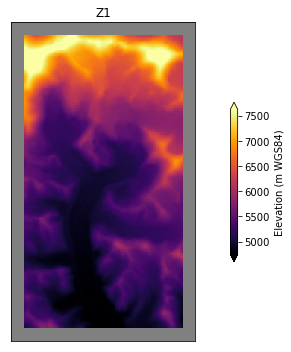

In [7]:
titles = ['Z1']
z1_full2plot = gf.z1
z1_full2plot.mask = dems_mask
clim = malib.calcperc(z1_full2plot, (2,98))
plot_array(z1_full2plot, clim, titles, 'inferno', 'Elevation (m WGS84)', fn=outdir_fig + glac_str + '_dem.png')

RGI60-15.03473


Text(0.5, 1, 'UTM (m)')

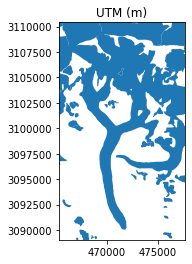

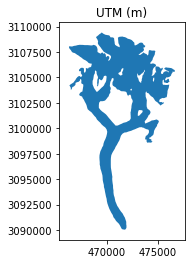

In [8]:
# Plot single glacier
rgiid = 'RGI60-' + gf.feat_fn.split('_')[0].split('.')[0].zfill(2) + '.' + gf.feat_fn.split('_')[0].split('.')[1]
glac_shp_proj = gpd.read_file(glac_shp_proj_fn)
glac_shp_single = glac_shp_proj[glac_shp_proj['RGIId'] == rgiid]
glac_shp_single = glac_shp_single.reset_index()

print(rgiid)

# Plot over region of interest
ax = glac_shp_proj.plot()
xlim = (warp_extent[0], warp_extent[2])
ylim = (warp_extent[1], warp_extent[3])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("UTM (m)") 

ax = glac_shp_single.plot()
xlim = (warp_extent[0], warp_extent[2])
ylim = (warp_extent[1], warp_extent[3])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("UTM (m)")

(428, 248)


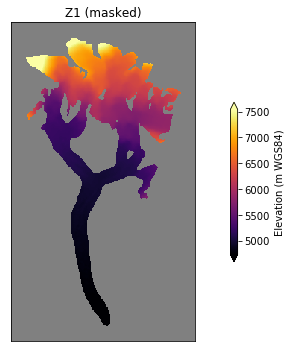

In [9]:
#Now apply glacier mask AND mask NaN values
glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
# nan_mask = np.ma.masked_invalid(gf.dz)
# glac_geom_mask = np.ma.mask_or(glac_geom_mask, nan_mask.mask)
gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)
# gf.z2 = np.ma.array(gf.z2, mask=glac_geom_mask)
# gf.dz = np.ma.array(gf.dz, mask=glac_geom_mask)

gf.res = geolib.get_res(ds_dict['z1'])

# print('dz_count:', gf.dz.count())
# print(gf.dz.compressed()))

# #Compute area covered by valid pixels in m2
# gf.valid_area = gf.dz.count() * gf.res[0] * gf.res[1]
# #Compute percentage covered by total area of polygon
# gf.valid_area_perc = 100. * (gf.valid_area / gf.glac_area)
# if verbose:
#     print('valid area %:', gf.valid_area_perc)

# titles = ['Z1']
# z1_full2plot = gf.z1
# z1_full2plot.mask = dems_mask
# clim = malib.calcperc(z1_full2plot, (2,98))
# plot_array(z1_full2plot, clim, titles, 'inferno', 'Elevation (m WGS84)', fn='dem.png')

titles = ['Z1 (masked)']
clim = malib.calcperc(gf.z1, (2,98))
plot_array(gf.z1, clim, titles, 'inferno', 'Elevation (m WGS84)', fn=outdir_fig + glac_str + '_dem.png')

print(gf.z1.shape)

In [10]:
print('\n\nHACK TO BYPASS VALID AREA\n\n')
gf.valid_area_perc = 100

if gf.valid_area_perc < (100. * min_valid_area_perc):
    if verbose:
        print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
#     return None

else:
    #Filter dz - throw out abs differences >150 m

    #Compute dz, volume change, mass balance and stats
    gf.z1_stats = malib.get_stats(gf.z1)
    z1_elev_med = gf.z1_stats[5]
    z1_elev_min, z1_elev_max = malib.calcperc(gf.z1, (0.1, 99.9))
    
    #Caluclate stats for aspect and slope using z2
    #Requires GDAL 2.1+
    gf.z1_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='aspect', returnma=True), mask=glac_geom_mask)
    gf.z1_aspect_stats = malib.get_stats(gf.z1_aspect)
    z1_aspect_med = gf.z1_aspect_stats[5]
    gf.z1_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='slope', returnma=True), mask=glac_geom_mask)
    gf.z1_slope_stats = malib.get_stats(gf.z1_slope)
    z1_slope_med = gf.z1_slope_stats[5]

#     #Load timestamp array, if available
#     if 'z1_date' in ds_dict:
#         gf.t1 = iolib.ds_getma(ds_dict['z1_date'])
#     else:
#         if isinstance(gf.t1, datetime):
#             gf.t1 = float(timelib.dt2decyear(gf.t1))
#         #else, assume we've hardcoded decimal year
#     gf.t1_mean = np.mean(gf.t1)

#     if 'z2_date' in ds_dict:
#         gf.t2 = iolib.ds_getma(ds_dict['z2_date'])
#     else:
#         if isinstance(gf.t2, datetime):
#             gf.t2 = float(timelib.dt2decyear(gf.t2))
#         #else, assume we've hardcoded decimal year
#     gf.t2_mean = np.mean(gf.t2)


    #Can estimate ELA values computed from hypsometry and typical AAR
    #For now, assume ELA is mean
    gf.z1_ela = None
    gf.z1_ela = gf.z1_stats[3]
#     gf.z2_ela = gf.z2_stats[3]
    #Note: in theory, the ELA should get higher with mass loss
    #In practice, using mean and same polygon, ELA gets lower as glacier surface thins
    if verbose:
        print("ELA(t1): %0.1f" % gf.z1_ela)
#         print("ELA(t2): %0.1f" % gf.z2_ela)

    """
    # This attempted to assign different densities above and below ELA
    if gf.z1_ela is None:
        gf.mb = gf.dhdt * rho_is
    else:
        #Initiate with average density
        gf.mb = gf.dhdt*(rho_is + rho_f)/2.
        #Everything that is above ELA at t2 is elevation change over firn, use firn density
        accum_mask = (gf.z2 > gf.z2_ela).filled(0).astype(bool)
    gf.mb[accum_mask] = (gf.dhdt*rho_f)[accum_mask]
    #Everything that is below ELA at t1 is elevation change over ice, use ice density
    abl_mask = (gf.z1 <= gf.z1_ela).filled(0).astype(bool)
    gf.mb[abl_mask] = (gf.dhdt*rho_is)[abl_mask]
    #Everything in between, use average of ice and firn density
    #mb[(z1 > z1_ela) || (z2 <= z2_ela)] = dhdt*(rhois + rho_f)/2.
    #Linear ramp
    #rho_f + z2*((rho_is - rho_f)/(z2_ela - z1_ela))
    #mb = np.where(dhdt < ela, dhdt*rho_i, dhdt*rho_s)
    """

    #Old approach
    #This is mb uncertainty map
    #gf.mb_sigma = np.ma.abs(gf.mb) * np.sqrt((rho_sigma/rho_is)**2 + (gf.dhdt_sigma/gf.dhdt)**2)
    #gf.mb_sigma_stats = malib.get_stats(gf.mb_sigma)
    #This is average mb uncertainty
    #gf.mb_mean_sigma = gf.mb_sigma_stats[3]

    #Now calculate mb for entire polygon
    #gf.mb_mean_totalarea = gf.mb_mean * gf.glac_area
    #Already have area uncertainty as percentage, just use directly
    #gf.mb_mean_totalarea_sigma = np.ma.abs(gf.mb_mean_totalarea) * np.sqrt((gf.mb_mean_sigma/gf.mb_mean)**2 + area_sigma_perc**2)

    #z2_elev_med, z2_elev_min, z2_elev_max, z2_elev_p16, z2_elev_p84, \
    outlist = [gf.glacnum, gf.cx, gf.cy, \
            z1_elev_med, z1_elev_min, z1_elev_max, \
            z1_slope_med, z1_aspect_med, \
#             gf.dhdt_mean, gf.dhdt_sigma, \
#             gf.mb_mean, gf.mb_mean_sigma, \
            gf.glac_area, 
#                gf.mb_total, gf.mb_total_sigma, \
#             gf.t1_mean, gf.t2_mean, gf.dt_mean, 
               gf.valid_area_perc]
    print(outlist)

    if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
        if 'ice_thick' in ds_dict:
            #Load ice thickness
            gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
            gf.H_mean = gf.H.mean()
        #These should be NaN or None
        outlist.append(gf.H_mean)
        print(outlist)

#         if 'debris_thick' in ds_dict:
#             gf.debris_thick = np.ma.array(iolib.ds_getma(ds_dict['debris_thick']), mask=glac_geom_mask)
#             gf.debris_thick_mean = gf.debris_thick.mean()
#         outlist.append(gf.debris_thick_mean)

#         if 'debris_class' in ds_dict:
#             #Load up debris cover maps
#             #Classes are: 1 = clean ice, 2 = debris, 3 = pond
#             gf.debris_class = np.ma.array(iolib.ds_getma(ds_dict['debris_class']), mask=glac_geom_mask)

#             #Compute debris/pond/clean percentages for entire polygon
#             if gf.debris_class.count() > 0:
#                 gf.perc_clean = 100. * (gf.debris_class == 1).sum()/gf.debris_class.count()
#                 gf.perc_debris = 100. * (gf.debris_class == 2).sum()/gf.debris_class.count()
#                 gf.perc_pond = 100. * (gf.debris_class == 3).sum()/gf.debris_class.count()
#             outlist.extend([gf.perc_debris, gf.perc_pond, gf.perc_clean])

        if 'vx' in ds_dict and 'vy' in ds_dict:
            #Load surface velocity maps
            gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
            gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
            gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
            gf.vm_mean = gf.vm.mean()
            
            print(gf.vm_mean)

            if gf.H is not None:
                #Compute flux
                gf.Q = gf.H * v_col_f * np.array([gf.vx, gf.vy])
                #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
                #Want x-derivative of x component
                gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

#                 gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
#                         + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

                #Should smooth divQ, better handling of data gaps
                
        if 'ts' in ds_dict:
            #Load surface temperature maps
            gf.ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
        else:
            gf.ts = None
            
        if 'debris_thick_ts' in ds_dict:
            # Load debris thickness map
            gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['debris_thick_ts']), mask=glac_geom_mask)
            gf.meltfactor_ts = None
        else:
            gf.debris_thick_ts = None
            gf.meltfactor_ts = None
    
        outlist.append(gf.vm_mean)
        print(outlist)

    if verbose:
        print('Area [km2]:', gf.glac_area / 1e6)
#         print('Mean mb: %0.2f +/- %0.2f mwe/yr' % (gf.mb_mean, gf.mb_mean_sigma))
#         print('Sum/Area mb: %0.2f mwe/yr' % (gf.mb_total/gf.glac_area))
#         print('Mean mb * Area: %0.2f +/- %0.2f m3we/yr' % (gf.mb_total, gf.mb_total_sigma))
# #         print('Sum mb: %0.2f m3we/yr' % gf.mb_total)
        print('-------------------------------')
    
    #Set up output header
    
    out_header = '%s,x,y,z_med,z_min,z_max,area_m2,valid_area_perc,slope_med,aspect_med' % glacnum_fieldname
    if extra_layers:
        out_header += ',H_m'
        out_header += ',vm_ma'

    nf = len(out_header.split(','))
    out_fmt = [glacnum_fmt,] + ['%0.3f'] * (nf - 1)
    
    #Write out mb stats for entire polygon - in case processing is interupted
    #out = np.array(outlist, dtype=float)
    out = np.full(len(out_fmt), np.nan)
    out[0:len(outlist)] = np.array(outlist, dtype=float)
    #Note, need a 2D array here, add 0 axis

    print(out)

    np.savetxt(out_csv_fn, out[np.newaxis,:], fmt=out_fmt, delimiter=',', header=out_header, comments='')
        



HACK TO BYPASS VALID AREA


ELA(t1): 5812.5
['15.03473', 471305.76429221936, 3103194.016120774, 5815.416015625, 4705.715529296875, 8160.9415585937495, 12.004107475280762, 179.98648071289062, 61006649.622459464, 100]
['15.03473', 471305.76429221936, 3103194.016120774, 5815.416015625, 4705.715529296875, 8160.9415585937495, 12.004107475280762, 179.98648071289062, 61006649.622459464, 100, 113.6750727250379]
13.25236868521326
['15.03473', 471305.76429221936, 3103194.016120774, 5815.416015625, 4705.715529296875, 8160.9415585937495, 12.004107475280762, 179.98648071289062, 61006649.622459464, 100, 113.6750727250379, 13.25236868521326]
Area [km2]: 61.00664962245946
-------------------------------
[1.50347300e+01 4.71305764e+05 3.10319402e+06 5.81541602e+03
 4.70571553e+03 8.16094156e+03 1.20041075e+01 1.79986481e+02
 6.10066496e+07 1.00000000e+02 1.13675073e+02 1.32523687e+01]


In [11]:
#Do AED for all
#Compute mb using scaled AED vs. polygon
#Check for valid pixel count vs. feature area, fill if appropriate

if mb_plot and (gf.glac_area_km2 > min_glac_area_writeout):
    print('plot?')
#     dz_clim = (-2.0, 2.0)
#     if site == 'hma':
#         dz_clim = (-3.0, 3.0)
    outbins_df, z_bin_edges = hist_plot(gf, outdir, bin_width=bin_width)
#     gf.z1_hs = geolib.gdaldem_mem_ds(ds_dict['z1'], processing='hillshade', returnma=True)
#     gf.z2_hs = geolib.gdaldem_mem_ds(ds_dict['z2'], processing='hillshade', returnma=True)
#     map_plot(gf, z_bin_edges, outdir, dz_clim=dz_clim)

plot?


In [12]:
outbins_df.loc[0:5,:]

,bin_center_elev_m,z1_bin_count_valid,z1_bin_area_valid_km2,z1_bin_area_perc,z2_bin_count_valid,z2_bin_area_valid_km2,z2_bin_area_perc,slope_bin_med,aspect_bin_med,debris_thick_ts_med_m,debris_thick_ts_mad_m,vm_med,vm_mad,H_mean,H_std
0,4702.5,14.0,0.0350,0.057371,14.0,0.0350,0.057371,1.360926,185.877014,0.090632,0.051189,0.677434,0.081405,103.078186,56.741047
1,4707.5,71.0,0.1775,0.290952,71.0,0.1775,0.290952,1.593543,186.678558,0.328358,0.392094,0.884432,0.156465,162.091660,68.578407
2,4712.5,67.0,0.1675,0.274560,67.0,0.1675,0.274560,3.396226,155.650848,0.090526,0.024658,0.970114,0.284121,186.559296,76.989418
3,4717.5,65.0,0.1625,0.266364,65.0,0.1625,0.266364,3.861753,161.546204,0.203175,0.206340,1.180802,0.455007,206.372742,74.864204
4,4722.5,74.0,0.1850,0.303246,74.0,0.1850,0.303246,3.149380,144.233887,0.482348,0.577716,1.059291,0.459528,177.316299,81.673698
5,4727.5,103.0,0.2575,0.422085,103.0,0.2575,0.422085,2.679566,148.247772,1.137931,0.356875,0.959151,0.322345,184.097565,78.452248


(428, 248)


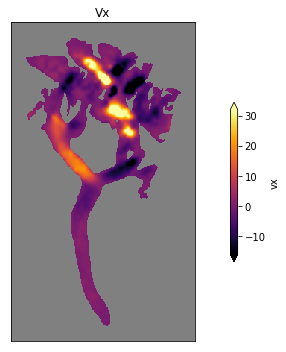

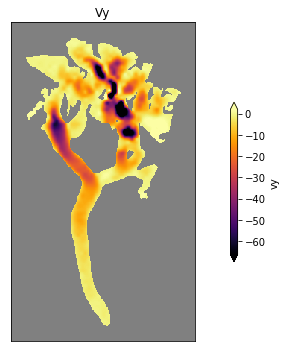

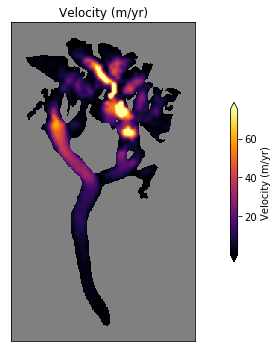

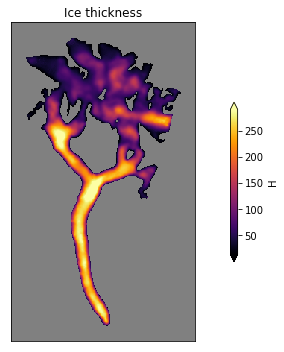

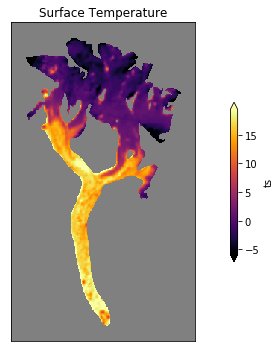

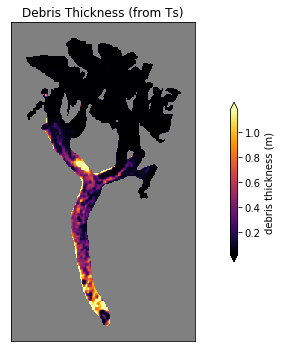

In [13]:
titles = ['Vx']
var_full2plot = gf.vx
var_full2plot.mask = glac_geom_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'vx', fn=outdir_fig + gf.feat_fn +'_vx.png')

titles = ['Vy']
var_full2plot = gf.vy
var_full2plot.mask = glac_geom_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'vy', fn=outdir_fig + gf.feat_fn +'_vy.png')

gf.vtot = (gf.vx**2 + gf.vy**2)**0.5

titles = ['Velocity (m/yr)']
var_full2plot = gf.vtot
var_full2plot.mask = glac_geom_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'Velocity (m/yr)', fn=outdir_fig + glac_str +'_velocity.png')

print(var_full2plot.shape)

titles = ['Ice thickness']
var_full2plot = gf.H
var_full2plot.mask = glac_geom_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'H', fn=outdir_fig + gf.feat_fn +'_ice_thickness.png')

titles = ['Surface Temperature']
var_full2plot = gf.ts
var_full2plot.mask = glac_geom_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'ts', fn=outdir_fig + gf.feat_fn +'_Ts.png')

if gf.debris_thick_ts is not None:
    titles = ['Debris Thickness (from Ts)']
    var_full2plot = gf.debris_thick_ts
    var_full2plot.mask = glac_geom_mask
    clim = malib.calcperc(var_full2plot, (2,98))
    plot_array(var_full2plot, clim, titles, 'inferno', 'debris thickness (m)', fn=outdir_fig + gf.feat_fn +'_debris_thickness.png')

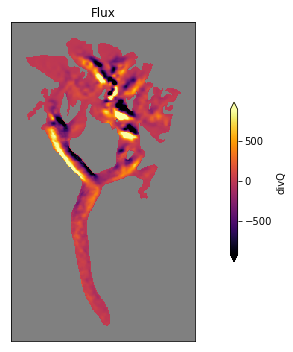

In [14]:
titles = ['Flux']
divQ_full2plot = gf.divQ
divQ_full2plot.mask = glac_geom_mask
clim = malib.calcperc(divQ_full2plot, (2,98))
plot_array(divQ_full2plot, clim, titles, 'inferno', 'divQ', fn=outdir_fig + glac_str +'_divQ.png')

In [15]:
def emergence_pixels(vel_x_raw, vel_y_raw, icethickness_raw, xres, yres, 
                     vel_min=0, max_velocity=600, vel_depth_avg_factor=0.8, option_border=1,
                     positive_is_east=True, positive_is_north=True, constant_icethickness=False):
    """ Compute the emergence velocity using an ice flux approach
    """
    # Modify vel_y by multiplying velocity by -1 such that matrix operations agree with flow direction
    #    Specifically, a negative y velocity means the pixel is flowing south.
    #    However, if you were to subtract that value from the rows, it would head north in the matrix.
    #    This is due to the fact that the number of rows start at 0 at the top.
    #    Therefore, multipylying by -1 aligns the matrix operations with the flow direction
    if positive_is_north:
        vel_y = -1*vel_y_raw * vel_depth_avg_factor
    else:
        vel_y = vel_y_raw * vel_depth_avg_factor
    if positive_is_east:
        vel_x = vel_x_raw * vel_depth_avg_factor
    else:
        vel_x = -1*vel_x_raw * vel_depth_avg_factor
    vel_total = (vel_y**2 + vel_x**2)**0.5
    # Ice thickness
    icethickness = icethickness_raw.copy()
    if constant_icethickness:
        icethickness[:,:] = 1
    print('mean ice thickness:', np.round(icethickness.mean(),0), 'm')
    # Compute the initial volume
    volume_initial = icethickness * (xres * yres)
    pix_maxres = xres
    if yres > pix_maxres:
        pix_maxres = yres
    # Quality control options:
    # Apply a border based on the max specified velocity to prevent errors associated with pixels going out of bounds
    if option_border == 1:
        border = int(max_velocity / pix_maxres) + 1
        for r in range(vel_x.shape[0]):
            for c in range(vel_x.shape[1]):
                if (r < border) | (r >= vel_x.shape[0] - border) | (c < border) | (c >= vel_x.shape[1] - border):
                    vel_x[r,c] = 0
                    vel_y[r,c] = 0
    # Minimum/maximum velocity bounds
    vel_x[vel_total < vel_min] = 0
    vel_y[vel_total < vel_min] = 0
    vel_x[vel_total > max_velocity] = 0
    vel_y[vel_total > max_velocity] = 0
#     # Remove clusters of high velocity on stagnant portions of glaciers due to feature tracking of ice cliffs and ponds
#     if option_stagnantbands == 1:
#         vel_x[bands <= stagnant_band] = 0
#         vel_y[bands <= stagnant_band] = 0        
    # Compute displacement in units of pixels
    vel_x_pix = vel_x / xres
    vel_y_pix = vel_y / yres
    # Compute the displacement and fraction of pixels moved for all columns (x-axis)
    # col_x1 is the number of columns to the closest pixel receiving ice [ex. 2.6 returns 2, -2.6 returns -2]
    #    int() automatically rounds towards zero
    col_x1 = vel_x_pix.astype(int)
    # col_x2 is the number of columns to the further pixel receiving ice [ex. 2.6 returns 3, -2.6 returns -3]
    #    np.sign() returns a value of 1 or -1, so it's adding 1 pixel away from zero
    col_x2 = (vel_x_pix + np.sign(vel_x_pix)).astype(int)
    # rem_x2 is the fraction of the pixel that remains in the further pixel (col_x2) [ex. 2.6 returns 0.6, -2.6 returns 0.6]
    #    np.sign() returns a value of 1 or -1, so multiplying by that ensures you have a positive value
    #    then when you take the remainder using "% 1", you obtain the desired fraction
    rem_x2 = np.multiply(np.sign(vel_x_pix), vel_x_pix) % 1
    # rem_x1 is the fraction of the pixel that remains in the closer pixel (col_x1) [ex. 2.6 returns 0.4, -2.6 returns 0.4]
    rem_x1 = 1 - rem_x2
    # Repeat the displacement and fraction computations for all rows (y-axis)
    row_y1 = vel_y_pix.astype(int)
    row_y2 = (vel_y_pix + np.sign(vel_y_pix)).astype(int)
    rem_y2 = np.multiply(np.sign(vel_y_pix), vel_y_pix) % 1
    rem_y1 = 1 - rem_y2
          
    # Fill masked values with 0
    col_x1[col_x1.mask] = 0
    col_x2[col_x2.mask] = 0
    row_y1[row_y1.mask] = 0
    row_y2[row_y2.mask] = 0
          
    # Compute the mass flux for each pixel
    volume_final = np.zeros(volume_initial.shape)
    for r in range(vel_x.shape[0]):
        for c in range(vel_x.shape[1]):
            volume_final[r+row_y1[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x1[r,c]] + rem_y1[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x1[r,c]] + rem_y2[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y1[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x2[r,c]] + rem_y1[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x2[r,c]] + rem_y2[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
    # Check that mass is conserved (threshold = 0.1 m x pixel_size**2)
    print('Mass is conserved?', (volume_final.sum() - volume_initial.sum()) < 0.1 * (xres * yres))
    print(np.nansum(volume_final) - np.nansum(volume_initial))
    # Final ice thickness
    icethickness_final = volume_final / (xres * yres)
    # Emergence velocity
    emergence_velocity = icethickness_final - icethickness
    return emergence_velocity

# # Emergence computation
# gf.emvel = emergence_pixels(gf.vx, gf.vy, gf.H, gf.res[0], gf.res[1], positive_is_east=False, 
#                             positive_is_north=False, constant_icethickness=False, max_velocity=600, vel_min=0)

# titles = ['Emergence Velocity']
# var_full2plot = gf.emvel
# var_full2plot.mask = dems_mask
# clim = malib.calcperc(var_full2plot, (2,98))
# plot_array(var_full2plot, clim, titles, 'inferno', 'emvel', fn= outdir_fig + glac_str +'_emergence_velocity.png')

In [16]:
print('\n\n\n===== HERE IS WHERE WE USED TO SWITCH TO THE hma_melt2thickness.py: =====' + 
      '\n  1. need meltmodel output for subdebris melt inversion\n\n\n')




===== HERE IS WHERE WE USED TO SWITCH TO THE hma_melt2thickness.py: =====
  1. need meltmodel output for subdebris melt inversion





In [17]:
print('Processing melt2thickness.py in notebook instead of in file')
import os
#import rasterio
#import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#%% ===== Input Data =====
# debris_thicknesses = list(np.arange(2,500,2))
debris_thicknesses = list(np.arange(0,500,10))
debris_thicknesses[0] = 2

output_sample_fn = 'Rounce2015_' + input.roi + '_debris_XXcm_20191206.csv'
output_data_fp = input.main_directory + '/hma_data/output/exp3_20191206/'
output_fp = input.main_directory + '/hma_data/output/'
if os.path.exists(output_fp) == False:
    os.makedirs(output_fp)
mb_fullfn = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Shean_2019_0213/' + 
             'mb_combined_20190213_nmad_bins/' + gf.feat_fn + '_mb_bins.csv')

if ~os.path.exists(output_data_fp + output_sample_fn.replace('1',str(2))):
    print('\n\n\n!!!!! MUST RUN THE MELTMODEL.PY SCRIPT FIRST TO GET DATA FOR SUB-DEBRIS INVERSION !!!!!\n\n\n')

Processing melt2thickness.py in notebook instead of in file



!!!!! MUST RUN THE MELTMODEL.PY SCRIPT FIRST TO GET DATA FOR SUB-DEBRIS INVERSION !!!!!





In [18]:
#%% ===== Debris Thickness vs. Surface Lowering =====
debris_melt_df = pd.DataFrame(np.zeros((len(debris_thicknesses),2)), columns=['debris_thickness', 'melt_mwea'])
for ndebris, debris_thickness in enumerate(debris_thicknesses):
    # Find correct model run date (end of the file name)
    if ndebris == 0:
        output_fn_split = output_sample_fn.split('_')
        output_fn_prefix = (output_fn_split[0] + '_' + output_fn_split[1] + '_' + output_fn_split[2] + '_' + 
                            str(debris_thickness) + 'cm')
        for i in os.listdir(output_data_fp):
            if i.startswith(output_fn_prefix) and i.endswith('.csv'):
                output_sample_fn = i.replace(str(debris_thickness) + 'cm', 'XXcm')
    output_fn = output_sample_fn.replace('XX',str(debris_thickness))
    output_fullfn = output_data_fp + output_fn
    # Hack because sometimes output debris thickness 1cm less due to the integer rounding
    if os.path.exists(output_fullfn) == False:
        output_fullfn = output_data_fp + output_sample_fn.replace('XX',str(debris_thickness-1))
    
    output_ds = pd.read_csv(output_fullfn)
    output_ds['Time'] = [np.datetime64(x) for x in output_ds['Time'].values]
    
    melt_mwea = (output_ds['Melt [mwe]'].sum() / 
                 ((output_ds['Time'].values[-1] - output_ds['Time'].values[0]).astype('timedelta64[D]').astype(int) 
                  / 365.25))
    debris_melt_df.loc[ndebris] = debris_thickness / 100, melt_mwea
    print(str(np.round(debris_thickness/100,2)) + ' m: ' + str(np.round(melt_mwea,2)) + ' mwea')

0.02 m: 6.21 mwea
0.1 m: 2.97 mwea
0.2 m: 1.52 mwea
0.3 m: 0.94 mwea
0.4 m: 0.69 mwea
0.5 m: 0.56 mwea
0.6 m: 0.48 mwea
0.7 m: 0.42 mwea
0.8 m: 0.38 mwea
0.9 m: 0.34 mwea
1.0 m: 0.31 mwea
1.1 m: 0.28 mwea
1.2 m: 0.26 mwea
1.3 m: 0.24 mwea
1.4 m: 0.23 mwea
1.5 m: 0.21 mwea
1.6 m: 0.2 mwea
1.7 m: 0.19 mwea
1.8 m: 0.18 mwea
1.9 m: 0.17 mwea
2.0 m: 0.16 mwea
2.1 m: 0.15 mwea
2.2 m: 0.14 mwea
2.3 m: 0.14 mwea
2.4 m: 0.13 mwea
2.5 m: 0.12 mwea
2.6 m: 0.12 mwea
2.7 m: 0.11 mwea
2.8 m: 0.11 mwea
2.9 m: 0.1 mwea
3.0 m: 0.1 mwea
3.1 m: 0.09 mwea
3.2 m: 0.09 mwea
3.3 m: 0.09 mwea
3.4 m: 0.08 mwea
3.5 m: 0.08 mwea
3.6 m: 0.07 mwea
3.7 m: 0.07 mwea
3.8 m: 0.07 mwea
3.9 m: 0.06 mwea
4.0 m: 0.06 mwea
4.1 m: 0.06 mwea
4.2 m: 0.06 mwea
4.3 m: 0.05 mwea
4.4 m: 0.05 mwea
4.5 m: 0.05 mwea
4.6 m: 0.05 mwea
4.7 m: 0.04 mwea
4.8 m: 0.04 mwea
4.9 m: 0.04 mwea


In [19]:
# fit_idx = np.where(debris_melt_df.debris_thickness <= 5)[0]
fit_idx = list(debris_melt_df.index.values)
fit_idx = fit_idx[2:]
print('Fit to a subset of data (not thinnest values) to capture this portion of the curve well' + 
      '\n  - any discrepancies at < 0.1 m are going to be very small because melt varies so drastically\n\n')

print(debris_melt_df.loc[fit_idx,'debris_thickness'].values)

Fit to a subset of data (not thinnest values) to capture this portion of the curve well
  - any discrepancies at < 0.1 m are going to be very small because melt varies so drastically


[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9
 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7
 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]


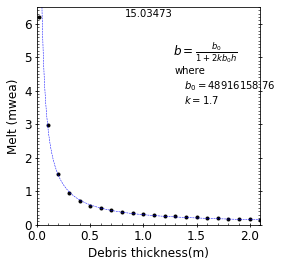

In [20]:
# PLOT CURVE
# fit curve
def melt_fromdebris_func(h, a, k):
    """ estimate melt from debris thickness (h is debris thickness, a and k are coefficients) """
    return a / (1 + 2 * k * a * h)
def debris_frommelt_func(b, a, k):
    """ estimate debris thickness from melt (b is melt, a and k are coefficients) """
    return (a - b) / (2*k*a*b)
func_coeff, pcov = curve_fit(melt_fromdebris_func, 
                             debris_melt_df.debris_thickness.values[fit_idx], 
                             debris_melt_df.melt_mwea.values[fit_idx])
func_coeff_meltfromdebris = func_coeff.copy()
fit_melt = melt_fromdebris_func(debris_melt_df.debris_thickness.values, func_coeff[0], func_coeff[1])
debris_4curve = np.arange(0.01,5.01,0.01)
melt_4curve = melt_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1])

# plot curve
fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
ax[0,0].plot(debris_melt_df['debris_thickness'], debris_melt_df['melt_mwea'], 'o', 
             color='k', markersize=3, zorder=1)
ax[0,0].plot(debris_4curve, melt_4curve, 
             color='b', linewidth=0.5, linestyle='--', zorder=2, label='plot1')
# text
ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
             transform=ax[0,0].transAxes)
eqn_text = r'$b = \frac{b_{0}}{1 + 2kb_{0}h}$'
coeff1_text = r'$b_{0} = ' + str(np.round(func_coeff[0],2)) + '$' 
coeff2_text = r'$k = ' + str(np.round(func_coeff[1],2)) + '$' 
# coeff$\frac{b_{0}}{1 + 2kb_{0}h}$'
ax[0,0].text(0.9, 0.85, eqn_text, size=12, horizontalalignment='right', verticalalignment='top', 
             transform=ax[0,0].transAxes)
ax[0,0].text(0.615, 0.73, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
             transform=ax[0,0].transAxes)
ax[0,0].text(0.66, 0.67, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
             transform=ax[0,0].transAxes)
ax[0,0].text(0.66, 0.6, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
             transform=ax[0,0].transAxes)
# X-label
ax[0,0].set_xlabel('Debris thickness(m)', size=12)
ax[0,0].set_xlim(0, 2.1)
#ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
ax[0,0].xaxis.set_tick_params(labelsize=12)
ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# Y-label
ax[0,0].set_ylabel('Melt (mwea)', size=12)
ax[0,0].set_ylim(0,(int(debris_melt_df.melt_mwea.values.max()/0.1)+3)*0.1)
ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(1))
ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(0.1))
# Tick parameters
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')               
# Save plot
fig.set_size_inches(4, 4)
figure_fn = 'debris_melt_curve.png'
fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  


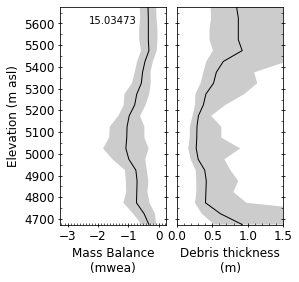

In [21]:
#%% ===== DERIVE DEBRIS THICKNESS FROM MASS BALANCE DATA =====
mb_df = pd.read_csv(mb_fullfn)
mb_df.loc[:,:] = mb_df.values.astype(np.float64)
mb_df['debris_thickness'] = debris_frommelt_func(-1*mb_df[' mb_bin_mean_mwea'].values, func_coeff[0], func_coeff[1])
mb_df['mb_bin_mean_mwea_1stdlow'] = mb_df[' mb_bin_mean_mwea'] - mb_df[' mb_bin_std_mwea']
mb_df['mb_bin_mean_mwea_1stdhigh'] = mb_df[' mb_bin_mean_mwea'] + mb_df[' mb_bin_std_mwea']
mb_df['debris_thickness_1stdlow'] = debris_frommelt_func(-1*mb_df['mb_bin_mean_mwea_1stdlow'].values, 
                                                          func_coeff[0], func_coeff[1])
mb_df['debris_thickness_1stdhigh'] = debris_frommelt_func(-1*mb_df['mb_bin_mean_mwea_1stdhigh'].values, 
                                                          func_coeff[0], func_coeff[1])

# PLOT MASS BALANCE AND DEBRIS THICKNESS VS. ELEVATION WITHOUT EMERGENCE VELOCITIES
# Mass balance
fig, ax = plt.subplots(1, 2, squeeze=False, sharex=False, sharey=True, gridspec_kw = {'wspace':0.1, 'hspace':0.15})
ax[0,0].plot(mb_df[' mb_bin_mean_mwea'], mb_df['# bin_center_elev_m'], color='k', linewidth=1, zorder=2)
ax[0,0].fill_betweenx(mb_df['# bin_center_elev_m'], 
                      mb_df['mb_bin_mean_mwea_1stdlow'], mb_df['mb_bin_mean_mwea_1stdhigh'], 
                      facecolor='k', alpha=0.2, zorder=1)
# text
fig.text(0.5, 0.96, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
             transform=ax[0,0].transAxes)
# X-label
ax[0,0].set_xlabel('Mass Balance\n(mwea)', size=12)
ax[0,0].set_xlim(-3.25, 0.25)
#ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
ax[0,0].xaxis.set_tick_params(labelsize=12)
ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(1))
ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# Y-label
ylower = mb_df['# bin_center_elev_m'].min()
yupper = ylower + 1000
ax[0,0].set_ylabel('Elevation (m asl)', size=12)
ax[0,0].set_ylim(ylower,yupper)
ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(100))
ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(50))
# Tick parameters
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')       

# Debris thickness
ax[0,1].plot(mb_df['debris_thickness'], mb_df['# bin_center_elev_m'], color='k', linewidth=1, zorder=2)
#ax[0,0].plot(mb_df['MassBal_25'], mb_df['E'], color='k', linewidth=0.5, zorder=2)
#ax[0,0].plot(mb_df['MassBal_75'], mb_df['E'], color='k', linewidth=0.5, zorder=2)
ax[0,1].fill_betweenx(mb_df['# bin_center_elev_m'], 
                      mb_df['debris_thickness_1stdlow'], mb_df['debris_thickness_1stdhigh'], 
                      facecolor='k', alpha=0.2, zorder=1)
# X-label
ax[0,1].set_xlabel('Debris thickness\n(m)', size=12)
ax[0,1].set_xlim(0, 1.5) 
ax[0,1].xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax[0,1].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# Y-label
ax[0,1].set_ylim(ylower,yupper)
# Tick parameters
ax[0,1].yaxis.set_ticks_position('both')
ax[0,1].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,1].tick_params(axis='both', which='minor', labelsize=10, direction='in')       
        
# Save plot
fig.set_size_inches(4, 4)
figure_fn = 'elev_mb_debris.png'
fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300) 

# #%% ===== EMERGENCE VELOCITIES ==========================================
# # CURRENTLY PROCESSED IN IPYTHON NOTEBOOK USING SHEAN GMBTOOLS-TYPE FILE 'emergence_velocity.ipynb'
# emergence_fullfn = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Shean_2019_0213/' + 
#                     'mb_combined_20190213_nmad_bins/csv/' + gf.feat_fn + '_mb_bins_wemvel.csv')
# emergence_df = pd.read_csv(emergence_fullfn)
# emergence_df['area_cumsum'] = np.cumsum(emergence_df['z1_bin_area_valid_km2'])

# binsize_mb = mb_df.loc[1,'# bin_center_elev_m'] - mb_df.loc[0,'# bin_center_elev_m']
# emvel_binsize = emergence_df['# bin_center_elev_m'].values[1] - emergence_df['# bin_center_elev_m'].values[0]
# emergence_shift_idx = np.where(emergence_df.area_cumsum.values < mb_df.loc[0,' z1_bin_area_valid_km2'])[0][-1]
# mb_offset = (mb_df.loc[0, '# bin_center_elev_m'] + binsize_mb/2 - emvel_binsize / 2 - 
#              emergence_df.loc[emergence_shift_idx, '# bin_center_elev_m'])
                      
# emergence_df['# bin_center_elev_m'] = emergence_df['# bin_center_elev_m'] + mb_offset
# emergence_df['E_low'] = emergence_df['# bin_center_elev_m'] - emvel_binsize/2
# emergence_df['E_high'] = emergence_df['# bin_center_elev_m'] + emvel_binsize/2

# # Get mean emergence velocity to coincide with elevation bins
# mb_df['E_low'] =  mb_df['# bin_center_elev_m'] - binsize_mb/2
# mb_df['E_high'] = mb_df['# bin_center_elev_m'] + binsize_mb/2

# mb_df['em_idx_low'] = np.nan
# mb_df['em_idx_high'] = np.nan
# for x in mb_df.index.values:
#     rows_low = np.where(mb_df.E_low.values[x] == emergence_df.E_low.values)[0]
#     if len(rows_low) > 0:
#         mb_df.loc[x,'em_idx_low'] = rows_low[0]
#     elif x == 0:
#         mb_df.loc[x,'em_idx_low'] = 0
        
#     rows_high = np.where(mb_df.E_high.values[x] == emergence_df.E_high.values)[0]
#     if len(rows_high) > 0:
#         mb_df.loc[x,'em_idx_high'] = rows_high[0]
#     elif len(rows_high) == 0 and ~np.isnan(mb_df.loc[x,'em_idx_low']):
#         mb_df.loc[x,'em_idx_high'] = emergence_df.index.values[-1]

# emergence_df['emvel*area'] = emergence_df.emvel_mean * emergence_df.z1_bin_area_valid_km2
# emergence_df['emvel*area_1stdlow'] = (emergence_df.emvel_mean - emergence_df.emvel_std) * emergence_df.z1_bin_area_valid_km2
# emergence_df['emvel*area_1stdhigh'] = (emergence_df.emvel_mean + emergence_df.emvel_std) * emergence_df.z1_bin_area_valid_km2
            
# mb_df['emvel_myr'] = np.nan
# for x in mb_df.index.values:
#     if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#         mb_df.loc[x,'emvel_myr'] = (
#                 emergence_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'emvel*area'].sum() / 
#                 emergence_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
# #larsen_data['emvel_myr_1stdlow'] = (
# #        [emvel_data.loc[larsen_data.loc[x,'em_idx_low']:larsen_data.loc[x,'em_idx_high'], 'emvel*area_1stdlow'].sum() / 
# #         emvel_data.loc[larsen_data.loc[x,'em_idx_low']:larsen_data.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum()
# #         for x in larsen_data.index.values])
# #larsen_data['emvel_myr_1stdhigh'] = (
# #        [emvel_data.loc[larsen_data.loc[x,'em_idx_low']:larsen_data.loc[x,'em_idx_high'], 'emvel*area_1stdhigh'].sum() / 
# #         emvel_data.loc[larsen_data.loc[x,'em_idx_low']:larsen_data.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum()
# #         for x in larsen_data.index.values])

# mb_df['mb_wem'] = mb_df[' mb_bin_mean_mwea'] - mb_df['emvel_myr']
# ##larsen_data['mb_wem_25'] = larsen_data['MassBal_25'] - larsen_data['emvel_myr_1stdhigh']
# ##larsen_data['mb_wem_75'] = larsen_data['MassBal_75'] - larsen_data['emvel_myr_1stdlow']
# #larsen_data['mb_wem_25'] = larsen_data['MassBal_25'] - larsen_data['emvel_myr']
# #larsen_data['mb_wem_75'] = larsen_data['MassBal_75'] - larsen_data['emvel_myr']
# #larsen_data['debris_thickness_wem'] = debris_frommelt_func(-1*larsen_data['mb_wem'].values, func_coeff[0], func_coeff[1])
# #larsen_data['debris_thickness_wem_25'] = debris_frommelt_func(-1*larsen_data['mb_wem_25'].values, 
# #                                                          func_coeff[0], func_coeff[1])
# #larsen_data['debris_thickness_wem_75'] = debris_frommelt_func(-1*larsen_data['mb_wem_75'].values, 
# #                                                          func_coeff[0], func_coeff[1])

# mb_df['debris_thickness_wem'] = debris_frommelt_func(-1*mb_df['mb_wem'].values, func_coeff[0], func_coeff[1])

# #%% ===== PLOT MASS BALANCE AND DEBRIS THICKNESS VS. ELEVATION WITH EMERGENCE VELOCITIES ======
# # Mass balance
# fig, ax = plt.subplots(1, 2, squeeze=False, sharex=False, sharey=True, gridspec_kw = {'wspace':0.1, 'hspace':0.15})
# ax[0,0].plot(mb_df['mb_wem'], mb_df['# bin_center_elev_m'], color='k', linewidth=1, zorder=2)
# #ax[0,0].fill_betweenx(mb_df['# bin_center_elev_m'], 
# #                      mb_df['mb_bin_mean_mwea_1stdlow'], mb_df['mb_bin_mean_mwea_1stdhigh'], 
# #                      facecolor='k', alpha=0.2, zorder=1)
# # text
# fig.text(0.5, 0.96, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# # X-label
# ax[0,0].set_xlabel('Mass Balance\n(mwea)', size=12)
# ax[0,0].set_xlim(-3.25, 0.25)
# #ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
# ax[0,0].xaxis.set_tick_params(labelsize=12)
# ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(1))
# ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# # Y-label
# ylower = mb_df['# bin_center_elev_m'].min()
# yupper = ylower + 1000
# ax[0,0].set_ylabel('Elevation (m asl)', size=12)
# ax[0,0].set_ylim(ylower,yupper)
# ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(100))
# ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(50))
# # Tick parameters
# ax[0,0].yaxis.set_ticks_position('both')
# ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')       

# # Debris thickness
# ax[0,1].plot(mb_df['debris_thickness_wem'], mb_df['# bin_center_elev_m'], color='k', linewidth=1, zorder=2)
# #ax[0,0].plot(mb_df['MassBal_25'], mb_df['E'], color='k', linewidth=0.5, zorder=2)
# #ax[0,0].plot(mb_df['MassBal_75'], mb_df['E'], color='k', linewidth=0.5, zorder=2)
# #ax[0,1].fill_betweenx(mb_df['# bin_center_elev_m'], 
# #                      mb_df['debris_thickness_1stdlow'], mb_df['debris_thickness_1stdhigh'], 
# #                      facecolor='k', alpha=0.2, zorder=1)
# # X-label
# ax[0,1].set_xlabel('Debris thickness\n(m)', size=12)
# ax[0,1].set_xlim(0, 1.5) 
# ax[0,1].xaxis.set_major_locator(plt.MultipleLocator(0.5))
# ax[0,1].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# # Y-label
# ax[0,1].set_ylim(ylower,yupper)
# # Tick parameters
# ax[0,1].yaxis.set_ticks_position('both')
# ax[0,1].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,1].tick_params(axis='both', which='minor', labelsize=10, direction='in')       
        
# # Save plot
# fig.set_size_inches(4, 4)
# figure_fn = 'elev_mb_debris_wem.png'
# fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300) 

In [22]:
debris_idx = np.where(mb_df[' perc_debris'] > 5)[0]
print(mb_df.loc[debris_idx,['# bin_center_elev_m', ' z1_bin_count_valid', ' z1_bin_area_valid_km2',
       ' z1_bin_area_perc', ' mb_bin_med_mwea',
       ' mb_bin_mad_mwea', ' mb_bin_mean_mwea', ' mb_bin_std_mwea',
       ' debris_thick_med_m', ' debris_thick_mad_m', ' perc_debris',
       ' perc_pond', ' perc_clean', ' vm_med', ' vm_mad', ' H_mean', ' H_std',
       'debris_thickness', 'mb_bin_mean_mwea_1stdlow',
       'mb_bin_mean_mwea_1stdhigh', 'debris_thickness_1stdlow',
       'debris_thickness_1stdhigh', 'emvel_myr', 'mb_wem', 'debris_thickness_wem']])

    # bin_center_elev_m   z1_bin_count_valid   z1_bin_area_valid_km2  \
0                4675.0               1459.0                   1.313   
1                4725.0               1885.0                   1.696   
2                4775.0               1561.0                   1.405   
3                4825.0               1862.0                   1.676   
4                4875.0               1637.0                   1.473   
5                4925.0               2310.0                   2.079   
6                4975.0               2168.0                   1.951   
7                5025.0               1948.0                   1.753   
8                5075.0               2276.0                   2.048   
9                5125.0               1242.0                   1.118   
10               5175.0               2441.0                   2.197   
11               5225.0               2631.0                   2.368   
12               5275.0               1317.0                   1

/Users/davidrounce/anaconda3/envs/debris_thickness_kennicott/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [23]:
print('\n\n\n===== HERE IS WHERE WE USED TO SWITCH TO THE hma_temp2thickness.py: =====' + 
      '\n  1. need surface temperature image (get from Google Earth Engine) for spatial distribution\n\n\n')




===== HERE IS WHERE WE USED TO SWITCH TO THE hma_temp2thickness.py: =====
  1. need surface temperature image (get from Google Earth Engine) for spatial distribution





In [24]:
#%% ===== Debris Thickness vs. Surface Temperature FOR SPECIFIC DATES=====
ts_cns = ['debris_thickness']
for ts_date in input.ts_dates:
    ts_cns.append('ts_degC_' + ts_date)
debris_ts_df = pd.DataFrame(np.zeros((len(debris_thicknesses),len(ts_cns))), columns=ts_cns)
debris_ts_df['debris_thickness'] = np.array(debris_thicknesses) / 100
# for ts_date in input.ts_dates:
#     print(ts_date)
#     ts_cn = 'ts_degC_' + ts_date 
#     for ndebris, debris_thickness in enumerate(debris_thicknesses):
#         output_fullfn = output_data_fp + output_sample_fn.replace('XX',str(debris_thickness))
        
#         # Hack because sometimes output debris thickness 1cm less due to the integer rounding
#         if os.path.exists(output_fullfn) == False:
#             output_fullfn = output_data_fp + output_sample_fn.replace('XX',str(debris_thickness-1))
        
        
#         output_ds = pd.read_csv(output_fullfn)
#         output_ds['Time_raw'] = output_ds['Time'].values
#         output_ds['YYYY-MM-DD'] = [output_ds['Time_raw'].values[x].split(' ')[0] for x in output_ds.index.values]
#         output_ds['Time'] = [np.datetime64(x) for x in output_ds['Time'].values]
#         ts_idx = list(output_ds['YYYY-MM-DD']).index(ts_date) + int(input.ts_hr)
#         ts_hr_adj = input.ts_hr%1   # amount to interpolate between values
        
#         ts_degC = (output_ds['Ts [K]'].values[ts_idx] + ts_hr_adj * (output_ds['Ts [K]'].values[ts_idx+1] - 
#                    output_ds['Ts [K]'].values[ts_idx]) - 273.15)
        
#         debris_ts_df.loc[ndebris, ts_cn] = ts_degC
#         print('  ', "{:.2f}".format(np.round(debris_thickness/100,2)) + ' m: ' + str(np.round(ts_degC,1)) + ' degC')

# # PLOT CURVES
# fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
# for ndate, ts_date in enumerate(input.ts_dates):
#     ts_cn = 'ts_degC_' + ts_date 
#     ax[0,0].plot(debris_ts_df['debris_thickness'], debris_ts_df[ts_cn], '-', zorder=1, label=ts_date)
# # text
# ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# # X-label
# ax[0,0].set_xlabel('Debris thickness(m)', size=12)
# ax[0,0].set_xlim(0, 5)
# #ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
# ax[0,0].xaxis.set_tick_params(labelsize=12)
# ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
# ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# # Y-label
# ax[0,0].set_ylabel('Ts (degC)', size=12)
# #ax[0,0].set_ylim(0,(int(debris_ts_df.melt_mwea.values.max()/0.1)+3)*0.1)
# ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(10))
# ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(2))
# # Tick parameters
# ax[0,0].yaxis.set_ticks_position('both')
# ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# # Legend
# ax[0,0].legend(fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, frameon=False)          
# # Save plot
# fig.set_size_inches(4, 4)
# figure_fn = 'debris_Ts_curve_specificdates.png'
# fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  
        
#%% ===== Debris Thickness vs. Surface Temperature - STATS OVER MELT SEASON=====
month_start = 8
month_end = 9
ts_cns = ['debris_thickness', 'ts_degC_mean', 'ts_degC_std', 'ts_degC_med', 'ts_degC_nmad']
debris_ts_df_stats = pd.DataFrame(np.zeros((len(debris_thicknesses),len(ts_cns))), columns=ts_cns)
debris_ts_df_stats['debris_thickness'] = np.array(debris_thicknesses) / 100

ts_hr_adj = input.ts_hr%1
for ndebris, debris_thickness in enumerate(debris_thicknesses):
    output_fullfn = output_data_fp + output_sample_fn.replace('XX',str(debris_thickness))
    
    # Hack because sometimes output debris thickness 1cm less due to the integer rounding
    if os.path.exists(output_fullfn) == False:
        output_fullfn = output_data_fp + output_sample_fn.replace('XX',str(debris_thickness-1))
            
    output_ds = pd.read_csv(output_fullfn)
    output_ds['Time'] = [np.datetime64(x) for x in output_ds['Time'].values]

    # Calculate the Ts at the acquisition time for all dates during melt season
    ts_11 = output_ds.loc[int(input.ts_hr)::24,['Time', 'Melt [mwe]', 'Ts [K]', 'Rn [W m2]', 'LE [W m2]', 
                                                'H [W m2]', 'P [W m2]', 'Qc [W m2]', 'd_snow [m]']]
    ts_12 = output_ds.loc[(int(input.ts_hr)+1)::24,['Time', 'Melt [mwe]', 'Ts [K]', 'Rn [W m2]', 'LE [W m2]', 
                                                    'H [W m2]', 'P [W m2]', 'Qc [W m2]', 'd_snow [m]']]
    ts_acq = ts_11.copy()
    ts_acq.loc[:,:] = (ts_11.values + ts_hr_adj * (ts_12.values - ts_11.values))
    ts_acq['Month'] = [ts_acq.loc[x,'Time'].month for x in ts_acq.index.values]
    ts_acq_month = ts_acq['Month'].values        
    ts_acq_subset = ts_acq.loc[(ts_acq['Month'] >= month_start) & (ts_acq['Month'] <= month_end),:]
    ts_acq_subset.reset_index(inplace=True, drop=True)
    
    # Remove snow
    ts_acq_subset_nosnow = ts_acq_subset.loc[(ts_acq_subset['d_snow [m]'] == 0), :]
    ts_acq_subset_nosnow.reset_index(inplace=True, drop=True)
    
    debris_ts_df_stats.loc[ndebris,'ts_degC_mean'] = ts_acq_subset_nosnow['Ts [K]'].mean() - 273.15
    debris_ts_df_stats.loc[ndebris,'ts_degC_std'] = ts_acq_subset_nosnow['Ts [K]'].std()
    debris_ts_df_stats.loc[ndebris,'ts_degC_med'] = ts_acq_subset_nosnow['Ts [K]'].median() - 273.15
    debris_ts_df_stats.loc[ndebris,'ts_degC_nmad'] = (
            1.483 * np.median(np.absolute(ts_acq_subset_nosnow['Ts [K]'] - 
                                          ts_acq_subset_nosnow['Ts [K]'].median()).values))
    
    print('  ', "{:.2f}".format(np.round(debris_thickness/100,2)) + ' m: ' + 
          str(np.round(debris_ts_df_stats.loc[ndebris,'ts_degC_mean'],1)) + ' degC')    


   0.02 m: 6.4 degC
   0.10 m: 14.0 degC
   0.20 m: 14.6 degC
   0.30 m: 15.3 degC
   0.40 m: 15.9 degC
   0.50 m: 16.5 degC
   0.60 m: 17.0 degC
   0.70 m: 17.4 degC
   0.80 m: 17.8 degC
   0.90 m: 18.1 degC
   1.00 m: 18.5 degC
   1.10 m: 18.8 degC
   1.20 m: 19.1 degC
   1.30 m: 19.3 degC
   1.40 m: 19.6 degC
   1.50 m: 19.8 degC
   1.60 m: 20.0 degC
   1.70 m: 20.2 degC
   1.80 m: 20.3 degC
   1.90 m: 20.5 degC
   2.00 m: 20.6 degC
   2.10 m: 20.8 degC
   2.20 m: 20.9 degC
   2.30 m: 21.0 degC
   2.40 m: 21.1 degC
   2.50 m: 21.2 degC
   2.60 m: 21.3 degC
   2.70 m: 21.4 degC
   2.80 m: 21.5 degC
   2.90 m: 21.6 degC
   3.00 m: 21.6 degC
   3.10 m: 21.7 degC
   3.20 m: 21.8 degC
   3.30 m: 21.8 degC
   3.40 m: 21.9 degC
   3.50 m: 21.9 degC
   3.60 m: 22.0 degC
   3.70 m: 22.0 degC
   3.80 m: 22.1 degC
   3.90 m: 22.1 degC
   4.00 m: 22.1 degC
   4.10 m: 22.2 degC
   4.20 m: 22.2 degC
   4.30 m: 22.3 degC
   4.40 m: 22.3 degC
   4.50 m: 22.3 degC
   4.60 m: 22.3 degC
   4.70 m: 22.

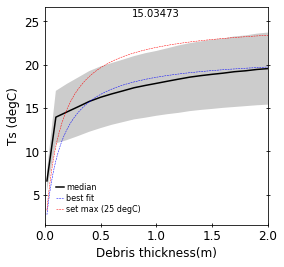

In [25]:
# ===== PLOT AND FIT CURVE (NONLINEAR REGRESSION) =====
## Kraaijenbrink et al. (2017)
##def ts_fromdebris_func(h, hmax, T95):
##    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
##    Kraaijenbrink et al. (2017) equation"""
##    return 0 + np.log(h*100) / np.log(hmax*100) * (T95 - 0)
##def debris_fromts_func(ts, hmax, T95):
##    """ estimate debris thickness from Ts (b is melt, a and k are coefficients) """
##    return np.exp((ts - 0) / (T95 - 0) * np.log(hmax)) / 100
#def ts_fromdebris_func(h, T95):
#    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
#    Kraaijenbrink et al. (2017) equation"""
#    return 0 + np.log(h*100) / np.log(1*100) * (T95 - 0)
#def debris_fromts_func(ts, T95):
#    """ estimate debris thickness from Ts (b is melt, a and k are coefficients) """
#    return np.exp((ts - 0) / (T95 - 0) * np.log(1)) / 100
#fit_idx = debris_ts_df_stats.index.values
#func_coeff, pcov = curve_fit(ts_fromdebris_func, 
#                             debris_ts_df_stats.debris_thickness.values[fit_idx], debris_ts_df_stats.ts_degC_med.values[fit_idx],
##                             p0=[30,0.3]
#                             )
#fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0])
#debris_4curve = np.arange(0.01,5.01,0.01)
#ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0])
#ts_4curve_setmax = ts_fromdebris_func(debris_4curve, func_coeff[0])
#label_4tscurve = 'Kra2017'
#figure_fn = 'debris_Ts_curve_Kra2017.png'

#def ts_fromdebris_func(h, a, k):
#    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
#    Michaelis-Menten Equation from single-substrate reactions"""
#    return a - a*np.exp(-k*h)
def ts_fromdebris_func(h, a, k):
    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
    hyperbolic fit"""
    return a * h / (k + h)
def debris_fromts_func(ts, a, k):
    """ estimate debris thickness from Ts (b is melt, a and k are coefficients) """
    return k * ts / (a - ts)

#fit_idx = debris_ts_df_stats.index.values
# fit_idx = [2,4,7,8,9,10,11,12,13,14]
# print('\nFIT ONLY TO DEBRIS THICKNESSES:', debris_ts_df_stats.debris_thickness.values[fit_idx], 
#       '\nTO ENSURE CAPTURES CURVE \n(plot with equal spacing to avoid this issue, but computationally expensive)')
func_coeff, pcov = curve_fit(ts_fromdebris_func, 
                             debris_ts_df_stats.debris_thickness.values[fit_idx], debris_ts_df_stats.ts_degC_med.values[fit_idx],
#                             p0=[30,0.3]
                             )
fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0], func_coeff[1])
debris_4curve = np.arange(0.02,5.01,0.01)
ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1])
ts_max = 25
ts_4curve_setmax = ts_fromdebris_func(debris_4curve, ts_max, func_coeff[1])
label_4tscurve = 'set max ('+ str(ts_max) + ' degC)'

if len(np.where(ts_4curve < 0)[0]) > 0:
    print('\nNEGATIVE FIT!\n')

figure_fn = 'debris_Ts_curve_avg_hyperbolic.png'

# plot curve
fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
#ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
             '-', color='k', zorder=1, label='median')
ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
                     debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
                     debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
                      facecolor='k', alpha=0.2, zorder=1)
ax[0,0].plot(debris_4curve, ts_4curve, 
             color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
ax[0,0].plot(debris_4curve, ts_4curve_setmax, 
             color='r', linewidth=0.5, linestyle='--', zorder=2, label=label_4tscurve)
# text
ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
             transform=ax[0,0].transAxes)
#eqn_text = r'$T_{s} = \frac{T_{s,max} h}{k + h}$'
#coeff1_text = r'$T_{s,max} = ' + str(np.round(func_coeff[0],2)) + '$' 
#coeff2_text = r'$k = ' + str(np.round(func_coeff[1],2)) + '$' 
## coeff$\frac{b_{0}}{1 + 2kb_{0}h}$'
#ax[0,0].text(0.05, 0.9, eqn_text, size=12, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.06, 0.79, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.09, 0.74, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.09, 0.67, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
# X-label
ax[0,0].set_xlabel('Debris thickness(m)', size=12)
ax[0,0].set_xlim(0, 2)
#ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
ax[0,0].xaxis.set_tick_params(labelsize=12)
#ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# Y-label
ax[0,0].set_ylabel('Ts (degC)', size=12)
#ax[0,0].set_ylim(0,(int(debris_ts_df.melt_mwea.values.max()/0.1)+3)*0.1)
#ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(10))
#ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(2))
# Tick parameters
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# Legend
ax[0,0].legend(loc=(0.05, 0.05), 
               fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
               frameon=False)          
# Save plot
fig.set_size_inches(4, 4)
fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  

In [26]:
print('\n\n===== PROCESS SURFACE TEMPERATURE DATA =====\n\n')



===== PROCESS SURFACE TEMPERATURE DATA =====




In [27]:
# ========== EQUATIONS EITHER MISS THE THIN DEBRIS OR THE THICK DEBRIS ==========
print('\n\nEQUATIONS MISS THIN OR THICK DEBRIS SO USE THE RAW DATA\n\n')



EQUATIONS MISS THIN OR THICK DEBRIS SO USE THE RAW DATA




In [28]:
debris_ts_df_stats

,debris_thickness,ts_degC_mean,ts_degC_std,ts_degC_med,ts_degC_nmad
0,0.02,6.402788,1.258326,6.594326,1.129090
1,0.10,13.996046,3.390951,13.954611,3.034682
2,0.20,14.626507,3.568762,14.559523,3.246728
3,0.30,15.259221,3.728283,15.158600,3.379960
4,0.40,15.925584,3.906852,15.774446,3.503099
5,0.50,16.479300,4.063201,16.247733,3.560294
6,0.60,16.958749,4.212197,16.636926,3.566648
7,0.70,17.390930,4.361287,16.986182,3.604584
8,0.80,17.785303,4.511369,17.346506,3.651298
9,0.90,18.146925,4.661445,17.611246,3.720232


Ts_max: 27.7


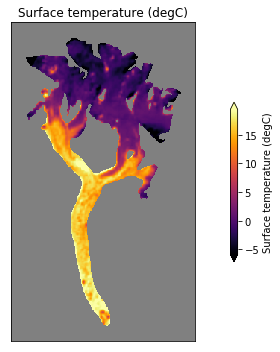

In [29]:
#Now apply glacier mask AND mask NaN values
# gf.ts = np.ma.array(iolib.ds_getma(ds_dict_ts['ts']), mask=glac_geom_mask)
# # glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
# gf.ts = np.ma.array(gf.ts, mask=glac_geom_mask)
# # gf.debris_thick_ts  = np.ma.masked_less_equal(gf.debris, 0)
# # gf.debris_thick_ts[gf.debris_thick_ts>1] = 1

gf.res = geolib.get_res(ds_dict['z1'])

print('Ts_max:', np.round(gf.ts.max(),1))

titles = ['Surface temperature (degC)']
clim = malib.calcperc(gf.ts, (2,98))
plot_array(gf.ts, clim, titles, 'inferno', 'Surface temperature (degC)', fn='../ts.png')

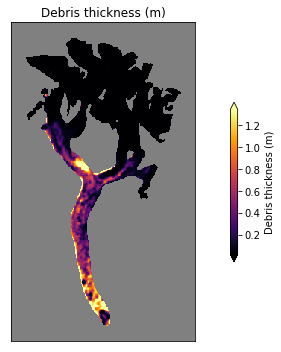

In [30]:
# Surface temperature dictionary
def ts_dict(debris_ts_df_stat, ts_offset=0):
    debris_ts_df_stats_adj = debris_ts_df_stats.copy()
    debris_ts_df_stats_adj['ts_degC_mean'] = debris_ts_df_stats_adj['ts_degC_mean'] + ts_offset
    debris_ts_df_stats_adj['ts_degC_med'] = debris_ts_df_stats_adj['ts_degC_med'] + ts_offset
    ts_str_subset = np.array([str(np.round(x,2)) for x in debris_ts_df_stats_adj.ts_degC_mean.values])
    ts_dict = dict(zip(ts_str_subset, debris_ts_df_stats_adj['debris_thickness']))
    ts_step = 0.01
    ts = np.arange(np.round(debris_ts_df_stats_adj['ts_degC_mean'].min(),2), 
                  np.round(debris_ts_df_stats_adj['ts_degC_mean'].max(),2), ts_step)
    ts_str = np.array([str(np.round(x,2)) for x in ts])
    ds_ts_filled = pd.DataFrame(np.zeros((ts_str.shape[0], 3)), columns=['ts', 'ts_str', 'thickness'])
    ds_ts_filled['ts'] = ts
    ds_ts_filled['ts_str'] = ts_str
    ds_ts_filled['thickness'] = ds_ts_filled.ts_str.map(ts_dict)
    ds_ts_filled = ds_ts_filled.interpolate(method='linear', axis=0)
    ts_dict_filled = dict(zip(ds_ts_filled.ts_str, ds_ts_filled.thickness))
    ts_dict_filled['nan'] = 0
#     print(ts_dict_filled)
    return ds_ts_filled, ts_dict_filled

def ts_to_debristhickness_fromdata(ts, debris_ts_df_stats, ts_offset=0):
    # Create dictionary
    ds_ts_filled, ts_dict_filled = ts_dict(debris_ts_df_stats, ts_offset=ts_offset)
    # Use dictionary to map thickness values
    gf.debris_thick_ts = ts.copy()
    gf.debris_thick_ts[gf.ts > ds_ts_filled.ts.max()] = ds_ts_filled.ts.max()
    gf.debris_thick_ts[gf.ts < ds_ts_filled.ts.min()] = ds_ts_filled.ts.min()
    # Round to nearest 0.01 deg and convert to string for dictionary
    gf.debris_thick_ts = np.round(gf.debris_thick_ts,2)
    gf.debris_thick_ts = gf.debris_thick_ts.astype(str)
    # Convert to thickness
    for key in ts_dict_filled:
        gf.debris_thick_ts[gf.debris_thick_ts == key] = ts_dict_filled[key]
    gf.debris_thick_ts = gf.debris_thick_ts.astype(float)
    return gf.debris_thick_ts

# process
# Estimate initial guess based on setting max to 2 m
# ts_clim = malib.calcperc(gf.ts, (2,98))
# debris_2m_idx = np.where(debris_ts_df_stats.debris_thickness == 2)[0][0]
# ts_offset_init = ts_clim[1] - debris_ts_df_stats.loc[debris_2m_idx,'ts_degC_mean']
# print(ts_clim[1], debris_ts_df_stats.loc[debris_2m_idx,'ts_degC_mean'], ts_offset_init)
# ts_offset_init = ts_clim[1] - debris_ts_df_stats.ts_degC_mean.max()
# print(ts_clim[1], debris_ts_df_stats.ts_degC_mean.max(), ts_offset_init)
# ts_offset_init = ts_clim[0] - debris_ts_df_stats.ts_degC_mean.min()
# print(ts_clim[0], debris_ts_df_stats.ts_degC_mean.max(), ts_offset_init)
ts_offset_init = 0

gf.debris_thick_ts = ts_to_debristhickness_fromdata(gf.ts, debris_ts_df_stats, ts_offset=ts_offset_init)
gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=glac_geom_mask)

gf.res = geolib.get_res(ds_dict['z1'])

titles = ['Debris thickness (m)']
clim = malib.calcperc(gf.debris_thick_ts, (2,98))
plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

# Export binned file
outbins_df, z_bin_edges = hist_plot(gf, outdir_csv, bin_width=bin_width)


In [31]:
# ===== COMPARE WITH DEBRIS THICKNESS DERIVED FROM MASS BALANCE DATA =====
outbins_df['area_cumsum'] = np.cumsum(outbins_df[' z1_bin_area_valid_km2'])

binsize_mb = mb_df.loc[1,'# bin_center_elev_m'] - mb_df.loc[0,'# bin_center_elev_m']
outbins_binsize = outbins_df['bin_center_elev_m'].values[1] - outbins_df['bin_center_elev_m'].values[0]
outbins_shift_idx = np.where(outbins_df.area_cumsum.values < mb_df.loc[0,' z1_bin_area_valid_km2'])[0][-1]
mb_offset = (mb_df.loc[0, '# bin_center_elev_m'] + binsize_mb/2 - outbins_binsize / 2 - 
             outbins_df.loc[outbins_shift_idx, 'bin_center_elev_m'])
                      
outbins_df['bin_center_elev_m'] = outbins_df['bin_center_elev_m'] + mb_offset
outbins_df['E_low'] = outbins_df['bin_center_elev_m'] - outbins_binsize/2
outbins_df['E_high'] = outbins_df['bin_center_elev_m'] + outbins_binsize/2

print(outbins_df.columns)

mb_df['E_low'] =  mb_df['# bin_center_elev_m'] - binsize_mb/2
mb_df['E_high'] = mb_df['# bin_center_elev_m'] + binsize_mb/2
mb_df['em_idx_low'] = np.nan
mb_df['em_idx_high'] = np.nan
for x in mb_df.index.values:
    rows_low = np.where(mb_df.E_low.values[x] == outbins_df.E_low.values)[0]
    if len(rows_low) > 0:
        mb_df.loc[x,'em_idx_low'] = rows_low[0]
    elif x == 0:
        mb_df.loc[x,'em_idx_low'] = 0
        
    rows_high = np.where(mb_df.E_high.values[x] == outbins_df.E_high.values)[0]
    if len(rows_high) > 0:
        mb_df.loc[x,'em_idx_high'] = rows_high[0]
    elif len(rows_high) == 0 and ~np.isnan(mb_df.loc[x,'em_idx_low']):
        mb_df.loc[x,'em_idx_high'] = outbins_df.index.values[-1]

outbins_df['debris*area'] = outbins_df['debris_thick_ts_med_m'] * outbins_df[' z1_bin_area_valid_km2']
outbins_df['debris*area_mad'] = outbins_df['debris_thick_ts_mad_m'] * outbins_df[' z1_bin_area_valid_km2']
mb_df['debris_thickness_fromTs'] = np.nan
mb_df['debris_thickness_fromTs_mad'] = np.nan
for x in mb_df.index.values:
    if ~np.isnan(mb_df.loc[x,'em_idx_low']):
        mb_df.loc[x,'debris_thickness_fromTs'] = (
                outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
                outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], ' z1_bin_area_valid_km2'].sum())
        mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
                outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
                outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], ' z1_bin_area_valid_km2'].sum())
# mb_df.to_csv(outdir_csv + '/' + gf.feat_fn + '_mb_bins_wdebris_inversions_fromdata_notopt.csv', index=False)
# mb_df.to_csv(outdir_csv + '/' + gf.feat_fn + 'mb_df_wTs.csv', index=False)

Index(['bin_center_elev_m', ' z1_bin_count_valid', ' z1_bin_area_valid_km2',
       ' z1_bin_area_perc', ' z2_bin_count_valid', ' z2_bin_area_valid_km2',
       ' z2_bin_area_perc', ' slope_bin_med', ' aspect_bin_med',
       'debris_thick_ts_med_m', 'debris_thick_ts_mad_m', ' vm_med', ' vm_mad',
       ' H_mean', ' H_std', 'area_cumsum', 'E_low', 'E_high'],
      dtype='object')


In [32]:
# ===== OPTIMIZE TS_MAX BASED ON THE SUBDEBRIS MELT INVERSION METHOD ======
from scipy.optimize import minimize

def objective(Ts_offset):
    """
    Objective function to fit Ts_offset for the surface temperature inversions to the subdebris melt inversions

    Parameters
    ----------
    Ts_offset : np.float64
        Temperature offset used to shift data/curve up or down

    Returns
    -------
    debris_dif
        Returns the difference in debris thickness for the subdebris and surface temp inversions
    """
    
    # Debris thickness from Hill Equation
    gf.debris_thick_ts = ts_to_debristhickness_fromdata(gf.ts, debris_ts_df_stats, ts_offset=Ts_offset)
    gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=glac_geom_mask)
    
    # Bin debris thicknesses
    outbins_df, z_bin_edges = hist_plot(gf, outdir_csv, bin_width=bin_width, exportcsv=False)
    
    outbins_df['debris*area'] = outbins_df['debris_thick_ts_med_m'] * outbins_df[' z1_bin_area_valid_km2']
    outbins_df['debris*area_mad'] = outbins_df['debris_thick_ts_mad_m'] * outbins_df[' z1_bin_area_valid_km2']
    mb_df['debris_thickness_fromTs'] = np.nan
    mb_df['debris_thickness_fromTs_mad'] = np.nan
    for x in mb_df.index.values:
        if ~np.isnan(mb_df.loc[x,'em_idx_low']):
            mb_df.loc[x,'debris_thickness_fromTs'] = (
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], ' z1_bin_area_valid_km2'].sum())
            mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], ' z1_bin_area_valid_km2'].sum())
    
    # Compare only over bins with low velocity and lots of debris
    vel_lt10_idx_raw = np.where((mb_df[' vm_med'] < 7.5) & (mb_df[' perc_debris'] > 50))[0]
    # only work with terminus
    vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
    if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
        vel_lt10_idx = vel_lt10_idx_raw
    else:
        idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
        vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]
    
    # Remove any bins with negative debris thickness
    vel_lt10_idx_posdebris = np.where(mb_df.loc[vel_lt10_idx,'debris_thickness'] > 0)[0]

    debris_dif_sum = (mb_df.loc[vel_lt10_idx_posdebris, 'debris_thickness_fromTs'] - 
                      mb_df.loc[vel_lt10_idx_posdebris,'debris_thickness']).sum()
    
    debris_dif_sum_abs = abs(debris_dif_sum)
    
    print(Ts_offset, debris_dif_sum_abs)

    return debris_dif_sum_abs

def run_objective(ts_offset):
    # Debris thickness from Hill Equation
    gf.debris_thick_ts = ts_to_debristhickness_fromdata(gf.ts, debris_ts_df_stats, ts_offset=ts_offset)
    gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=glac_geom_mask)
    
    # Bin debris thicknesses
    outbins_df, z_bin_edges = hist_plot(gf, outdir_csv, bin_width=bin_width, exportcsv=False)
    
    outbins_df['debris*area'] = outbins_df['debris_thick_ts_med_m'] * outbins_df[' z1_bin_area_valid_km2']
    outbins_df['debris*area_mad'] = outbins_df['debris_thick_ts_mad_m'] * outbins_df[' z1_bin_area_valid_km2']
    mb_df['debris_thickness_fromTs'] = np.nan
    mb_df['debris_thickness_fromTs_mad'] = np.nan
    for x in mb_df.index.values:
        if ~np.isnan(mb_df.loc[x,'em_idx_low']):
            mb_df.loc[x,'debris_thickness_fromTs'] = (
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], ' z1_bin_area_valid_km2'].sum())
            mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
                    outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], ' z1_bin_area_valid_km2'].sum())
    
    # Compare only over bins with low velocity and lots of debris
    vel_lt10_idx_raw = np.where((mb_df[' vm_med'] < 7.5) & (mb_df[' perc_debris'] > 50))[0]
    # only work with terminus
    vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
    if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
        vel_lt10_idx = vel_lt10_idx_raw
    else:
        idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
        vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]
    
    # Remove any bins with negative debris thickness
    vel_lt10_idx_posdebris = np.where(mb_df.loc[vel_lt10_idx,'debris_thickness'] > 0)[0]
    
#     if len(vel_lt10_idx_posdebris) > 5:
#         vel_lt10_idx_posdebris = vel_lt10_idx_posdebris[0:5]
#         print(vel_lt10_idx_posdebris)
    
    debris_dif_sum = (mb_df.loc[vel_lt10_idx_posdebris, 'debris_thickness_fromTs'] - 
                      mb_df.loc[vel_lt10_idx_posdebris,'debris_thickness']).sum()
    
    debris_dif_sum_abs = abs(debris_dif_sum)

    return mb_df, ts_offset_obj, vel_lt10_idx

In [33]:
ts_offset_obj = minimize(objective, ts_offset_init, method='SLSQP',
                      options={'ftol':1e-3, 'eps':0.1}
                     )
ts_offset_opt = ts_offset_obj.x[0]

print(ts_offset_opt)

mb_df, ts_offset_obj, vel_lt10_idx = run_objective(ts_offset_opt)

# eps_opt = 0.01
# n = 0
# while n < 5:
#     n += 1 
#     eps_opt = eps_opt*10
#     ts_offset_obj = minimize(objective, 0, method='SLSQP', options={'ftol':1e-3, 'eps':eps_opt})
#     ts_offset_opt = ts_offset_obj.x[0]
#     print('eps_opt:', eps_opt, 'ts_offset_opt:', ts_offset_opt)

mb_df['debris_dif'] =  mb_df['debris_thickness'] - mb_df['debris_thickness_fromTs']
cols2print = ['# bin_center_elev_m', ' mb_bin_mean_mwea', ' debris_thick_med_m', ' perc_debris',
              'debris_thickness', 'debris_thickness_fromTs', 'debris_dif']
print(mb_df.loc[vel_lt10_idx, cols2print])

[0.] 0.36803294411239473
[0.] 0.36803294411239473
[0.1] 0.274293881564711
[0.93739063] 0.4240329743331924
[0.44061473] 0.02631141552391203
[0.44061473] 0.02631141552391203
[0.54061473] 0.10958786615791472
[0.23332877] 0.15496687284049837
[0.38123098] 0.024469536452864094
[0.40977419] 3.5357385252399176e-05
[0.40977419] 3.5357385252399176e-05
[0.50977419] 0.08350558885994108
[-0.62906735] 1.0217450379425033
[0.17131907] 0.20958764544067232
[0.3516943] 0.05009816279945223
[0.39548753] 0.01542125335273592
[0.40665512] 0.004220765739057941
[0.40917612] 0.0034105300003036687
[0.40971438] 0.0009773491912826726
[0.40976821] 3.5357385252399176e-05
[0.4097712] 3.5357385252399176e-05
[0.40977269] 3.5357385252399176e-05
[0.40977344] 3.5357385252399176e-05
0.4097734421455375
   # bin_center_elev_m   mb_bin_mean_mwea   debris_thick_med_m   perc_debris  \
0               4675.0              -0.32                 0.38         82.31   
1               4725.0              -0.48                 0.36    



 BIN THE DEBRIS THICKNESS AND ADD DDF REDUCTION 





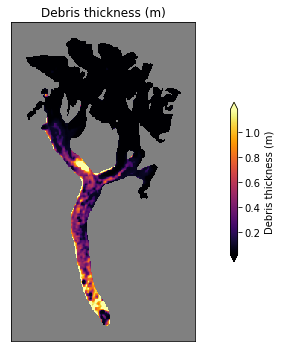

In [34]:
print('\n\n BIN THE DEBRIS THICKNESS AND ADD DDF REDUCTION \n\n\n')

# Plot debris thickness
gf.debris_thick_ts = ts_to_debristhickness_fromdata(gf.ts, debris_ts_df_stats, ts_offset=ts_offset_opt)
gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=glac_geom_mask)

gf.res = geolib.get_res(ds_dict['z1'])

titles = ['Debris thickness (m)']
clim = malib.calcperc(gf.debris_thick_ts, (2,98))
plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

# Export binned file
mb_df.to_csv(outdir_csv + '/' + gf.feat_fn + '_mb_bins_wdebris_fromTsdata.csv', index=False)

In [46]:
# Export debris thickness map
iolib.writeGTiff(gf.debris_thick_ts, debris_fullfn, ds_dict['z1'])

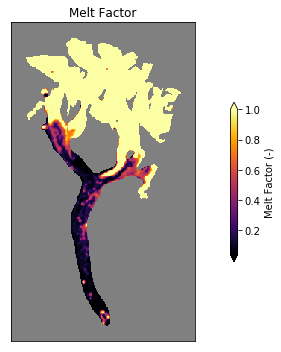

In [36]:
# ===== DEBRIS MELT ENHANCEMENT OR REDUCTION FACTOR =====
def meltfactor_fromdebris_func(h, a, k, melt_2cm):
    """ estimate melt factor from debris thickness (h is debris thickness, a and k are coefficients) """
    melt_h = a / (1 + 2 * k * a * h)
    melt_factor = melt_h / melt_2cm
    melt_factor[melt_factor > 1] = 1
    return melt_factor

idx_2cm = np.where(debris_melt_df.debris_thickness.values == 0.02)[0][0]
melt_2cm = debris_melt_df.loc[idx_2cm, 'melt_mwea']

outbins_df['meltfactor_ts'] = meltfactor_fromdebris_func(outbins_df['debris_thick_ts_med_m'].values, 
                                                         func_coeff_meltfromdebris[0], func_coeff_meltfromdebris[1], 
                                                         melt_2cm)

# Plot debris thickness
gf.meltfactor_ts = meltfactor_fromdebris_func(gf.debris_thick_ts, 
                                               func_coeff_meltfromdebris[0], func_coeff_meltfromdebris[1], 
                                               melt_2cm)
gf.meltfactor_ts = np.ma.array(gf.meltfactor_ts, mask=glac_geom_mask)

gf.res = geolib.get_res(ds_dict['z1'])

titles = ['Melt Factor']
clim = malib.calcperc(gf.meltfactor_ts, (2,98))
plot_array(gf.meltfactor_ts, clim, titles, 'inferno', 'Melt Factor (-)', fn='../meltfactor.png')

In [48]:
# Export melt factor map
meltfactor_fullfn = debris_fullfn.replace('_debristhickness_','_meltfactor_')
iolib.writeGTiff(gf.meltfactor_ts, meltfactor_fullfn, ds_dict['z1'])

In [37]:
# ====== PROCESS BINNED DEBRIS THICKNESS DATA FOR USE ======
outbins_df, z_bin_edges = hist_plot(gf, outdir, bin_width=10)

print('NOW EXPORT RESULTS TO FILE FORMAT WHERE ELEVATION IS CONSISTENT WITH FARINOTTI ICE THICKNESS!')

NOW EXPORT RESULTS TO FILE FORMAT WHERE ELEVATION IS CONSISTENT WITH FARINOTTI ICE THICKNESS!


In [38]:
debris_output_fp = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/output/'
debris_output_fn = 'debris_m_' + region.zfill(2) + '_10m.csv'
meltfactor_output_fn = 'meltfactor_' + region.zfill(2) + '_10m.csv'
hyps_fn = 'area_km2_' + region.zfill(2) + '_Farinotti2019_10m.csv'

# Load datasets or create a new dataset if it doesn't exist yet
area_df = pd.read_csv(debris_output_fp + hyps_fn)
if os.path.exists(debris_output_fp + debris_output_fn):
    debris_output = pd.read_csv(debris_output_fp + debris_output_fn)
    meltfactor_output = pd.read_csv(debris_output_fp + meltfactor_output_fn)
else:
    debris_output = pd.DataFrame(np.zeros(area_df.shape), columns=area_df.columns)
    debris_output['RGIId'] = area_df['RGIId']
    meltfactor_output = debris_output.copy()
    
rgi_idx = np.where(debris_output['RGIId'] == 'RGI60-' + glac_str)[0][0]
area_idx = np.where(area_df.iloc[rgi_idx,1:] > 0)[0]
area_cns = area_df.columns[1:][area_idx]

print(area_df.loc[rgi_idx, area_cns])

# All area that have ice set to clean ice to begin
debris_output.loc[rgi_idx, area_cns] = 0
meltfactor_output.loc[rgi_idx, area_cns] = 1
# add debris thickness and meltfactors
debris_cns = [str(int(np.round(x,0))) for x in outbins_df['bin_center_elev_m'].values]
debris_output.loc[rgi_idx, debris_cns] = outbins_df['debris_thick_ts_med_m'].values
meltfactor_output.loc[rgi_idx, debris_cns] = outbins_df['meltfactor_ts_med_m'].values

# Export files
debris_output.to_csv(debris_output_fp + debris_output_fn, index=False)
meltfactor_output.to_csv(debris_output_fp + meltfactor_output_fn, index=False)

print('\n\nAVOID LOADING AND EXPORTING EVERY GLACIER WHEN SCALING THIS UP - only do once at start and end\n\n')

print('\nClean ice has 0.02 m of debris (meltfactor = 1) - remove this so only debris covered areas have values\n')

4705    0.2175
4715    0.3225
4725    0.4675
4735    0.5825
4745      0.37
         ...  
8145    0.0375
8155    0.0275
8165    0.0275
8175    0.0325
8185     0.005
Name: 3472, Length: 349, dtype: object


AVOID LOADING AND EXPORTING EVERY GLACIER WHEN SCALING THIS UP - only do once at start and end



Clean ice has 0.02 m of debris (meltfactor = 1) - remove this so only debris covered areas have values



In [39]:
region

'15'

In [ ]:
print('\n\n\nOLD CODE NO LONGER RELEVANT\n\n')

# print('max Ts (degC):', np.round(gf.ts.max(),1))
# print('hill_coeff (a,b,c):', hill_func_coeff)

# # ===== ESTIMATE DEBRIS THICKNESS =====
# #Now apply glacier mask AND mask NaN values
# # # glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
# # # gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
# # k = 0.13
# # Tsmax_offset = 6
# # Tsmax = gf.ts.max() + Tsmax_offset
# # gf.debris_thick_ts = gf.ts * 0.13 / (Tsmax - gf.ts)

# Tsmax_offset = 0
# Tsmax = gf.ts.max() + Tsmax_offset
# gf.debris_thick_ts = debris_fromts_func_hill(gf.ts, hill_func_coeff[0], hill_func_coeff[1], hill_func_coeff[2])

# # gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=glac_geom_mask)
# # gf.debris_thick_ts  = np.ma.masked_less_equal(gf.debris_thick_ts, 0)
# # gf.debris_thick_ts[gf.debris_thic_tsk>1] = 1

# gf.res = geolib.get_res(ds_dict['z1'])

# titles = ['Debris thickness (m)']
# clim = malib.calcperc(gf.debris_thick_ts, (2,98))
# plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

# outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
# outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
# mb_df['debris_thickness_fromTs'] = np.nan
# mb_df['debris_thickness_fromTs_mad'] = np.nan
# for x in mb_df.index.values:
#     if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#         mb_df.loc[x,'debris_thickness_fromTs'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#         mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())

# print(mb_df.loc[debris_idx,['# bin_center_elev_m', ' vm_med', ' H_mean',
#        'debris_thickness', 'debris_thickness_1stdlow', 'debris_thickness_1stdhigh', 'debris_thickness_fromTs', 'debris_thickness_fromTs_mad']])

# ===== OPTIMIZE TS_MAX BASED ON THE SUBDEBRIS MELT INVERSION METHOD ======
# from scipy.optimize import minimize

# def objective(Ts_max):
#     """
#     Objective function to fit Ts_max for the surface temperature inversions to the subdebris melt inversions

#     Parameters
#     ----------
#     Ts_max : np.float64
#         Maximum surface temperature for Hill equation

#     Returns
#     -------
#     debris_dif
#         Returns the difference in debris thickness for the subdebris and surface temp inversions
#     """
    
#     # Debris thickness from Hill Equation
#     gf.debris_thick_ts = debris_fromts_func_hill(gf.ts, Ts_max, hill_func_coeff[1], hill_func_coeff[2])
    
#     # Bin debris thicknesses
#     outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
    
#     outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
#     outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
#     mb_df['debris_thickness_fromTs'] = np.nan
#     mb_df['debris_thickness_fromTs_mad'] = np.nan
#     for x in mb_df.index.values:
#         if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#             mb_df.loc[x,'debris_thickness_fromTs'] = (
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#             mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
    
#     # Compare only over bins with low velocity and lots of debris
#     vel_lt10_idx_raw = np.where((mb_df[' vm_med'] < 7.5) & (mb_df[' perc_debris'] > 50))[0]
#     # only work with terminus
#     vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
#     idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
#     vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]

#     debris_dif_sum = (mb_df.loc[vel_lt10_idx, 'debris_thickness_fromTs'] - mb_df.loc[vel_lt10_idx,'debris_thickness']).sum()
    
#     debris_dif_sum_abs = abs(debris_dif_sum)

#     return debris_dif_sum_abs


# ts_max_obj = minimize(objective, hill_func_coeff[0], method='SLSQP',
#                       options={'ftol':1e-3, 'eps':0.1}
#                      )
# ts_max_opt = ts_max_obj.x[0]

# print(ts_max_opt)

# ===== OUTPUT FINAL DEBRIS THICKNESS =====
# gf.debris_thick_ts = debris_fromts_func_hill(gf.ts, ts_max_opt, hill_func_coeff[1], hill_func_coeff[2])

# # gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=glac_geom_mask)
# # gf.debris_thick_ts  = np.ma.masked_less_equal(gf.debris_thick_ts, 0)
# # gf.debris_thick_ts[gf.debris_thick_ts>1] = 1

# gf.res = geolib.get_res(ds_dict['z1'])

# titles = ['Debris thickness (m)']
# clim = malib.calcperc(gf.debris_thick_ts, (2,98))
# plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

# # Plot optimized curve
# debris_4curve = np.arange(0.02,5.01,0.01)
# ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1], func_coeff[2])

# figure_fn = 'debris_Ts_curve_Hill_optimized.png'

# # plot curve
# fig, ax = plt.subplots(1, 2, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
# #ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
# ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
#              '-', color='k', zorder=1, label='median')
# ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
#                      debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
#                      debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
#                      facecolor='k', alpha=0.2, zorder=1)
# ax[0,0].plot(debris_4curve, ts_4curve, 
#              color='b', linewidth=0.5, linestyle='--', zorder=2, label='optimized')
# # text
# ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# # X-label
# ax[0,0].set_xlabel('Debris thickness(m)', size=12)
# ax[0,0].set_xlim(0, 2)
# ax[0,0].xaxis.set_tick_params(labelsize=12)
# # Y-label
# ax[0,0].set_ylabel('Ts (degC)', size=12)
# # Tick parameters
# ax[0,0].yaxis.set_ticks_position('both')
# ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# # Legend
# ax[0,0].legend(loc=(0.05, 0.05), 
#                fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
#                frameon=False)    

# ax[0,1].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
#              '-', color='k', zorder=1, label='median')
# ax[0,1].fill_between(debris_ts_df_stats['debris_thickness'], 
#                      debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
#                      debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
#                      facecolor='k', alpha=0.2, zorder=1)
# ax[0,1].plot(debris_4curve, ts_4curve, 
#              color='b', linewidth=0.5, linestyle='--', zorder=2, label='optimized')
# # text
# ax[0,1].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# # X-label
# ax[0,1].set_xlabel('Debris thickness(m)', size=12)
# ax[0,1].set_xlim(0, 0.25)
# ax[0,1].xaxis.set_tick_params(labelsize=12)
# # Y-label
# ax[0,1].set_ylabel('Ts (degC)', size=12)
# # Tick parameters
# ax[0,1].yaxis.set_ticks_position('both')
# ax[0,1].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,1].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# # Legend
# ax[0,1].legend(loc=(0.05, 0.05), 
#                fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
#                frameon=False)    

# # Save plot
# fig.set_size_inches(6, 4)
# fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300) 

# # Export binned file
# outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
# outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
# outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
# mb_df['debris_thickness_fromTs'] = np.nan
# mb_df['debris_thickness_fromTs_mad'] = np.nan
# for x in mb_df.index.values:
#     if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#         mb_df.loc[x,'debris_thickness_fromTs'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#         mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
# mb_df.to_csv(outdir_csv + '/' + glac_str + '_mb_bins_wdebris_inversions_Hill.csv', index=False)

In [ ]:
# #%% ===== THE "HILL" EQUATION FITS NGOZUMPA NICELY ======
# def ts_fromdebris_func(h, a, b, c):
#     """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
#     Hill Equation"""
#     return a * h**c / (b**c + h**c)
# def debris_fromts_func_hill(ts, a, b, c):
#     """ estimate debris thickness from surface temperature (ts is surface temperature, a and k are coefficients) 
#     Hill Equation"""
#     return (ts * b**c / (a - ts))**(1/c)

# #fit_idx = debris_ts_df_stats.index.values
# #fit_idx = [1,4,7,8,9,10,12]
# # fit_idx = [2,4,7,8,9,10,11,12,13,14]
# print('\nFIT ONLY TO DEBRIS THICKNESSES:', debris_ts_df_stats.debris_thickness.values[fit_idx], 
#       '\nTO ENSURE CAPTURES CURVE \n(plot with equal spacing to avoid this issue, but computationally expensive)')
# func_coeff, pcov = curve_fit(ts_fromdebris_func, 
#                              debris_ts_df_stats.debris_thickness.values[fit_idx], debris_ts_df_stats.ts_degC_med.values[fit_idx],
#                              p0=[25,1,1]
#                              )
# fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0], func_coeff[1], func_coeff[2])
# debris_4curve = np.arange(0.02,5.01,0.01)
# ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1], func_coeff[2])
# ts_max = 30
# ts_4curve_setmax = ts_fromdebris_func(debris_4curve, ts_max, func_coeff[1], func_coeff[2])
# label_4tscurve = 'set max ('+ str(ts_max) + ' degC)'

# if len(np.where(ts_4curve < 0)[0]) > 0:
#     print('\nNEGATIVE FIT!\n')

# figure_fn = 'debris_Ts_curve_avg_Hill.png'

# # plot curve
# fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
# #ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
# ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
#              '-', color='k', zorder=1, label='median')
# ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
#                      debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
#                      debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
#                       facecolor='k', alpha=0.2, zorder=1)
# ax[0,0].plot(debris_4curve, ts_4curve, 
#              color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
# ax[0,0].plot(debris_4curve, ts_4curve_setmax, 
#              color='r', linewidth=0.5, linestyle='--', zorder=2, label=label_4tscurve)
# # text
# ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# #eqn_text = r'$T_{s} = \frac{T_{s,max} h^}{k + h}$'
# #coeff1_text = r'$T_{s,max} = ' + str(np.round(func_coeff[0],2)) + '$' 
# #coeff2_text = r'$k = ' + str(np.round(func_coeff[1],2)) + '$' 
# # coeff$\frac{b_{0}}{1 + 2kb_{0}h}$'
# #ax[0,0].text(0.05, 0.9, eqn_text, size=12, horizontalalignment='left', verticalalignment='top', 
# #             transform=ax[0,0].transAxes)
# #ax[0,0].text(0.06, 0.79, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
# #             transform=ax[0,0].transAxes)
# #ax[0,0].text(0.09, 0.74, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
# #             transform=ax[0,0].transAxes)
# #ax[0,0].text(0.09, 0.67, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
# #             transform=ax[0,0].transAxes)
# # X-label
# ax[0,0].set_xlabel('Debris thickness(m)', size=12)
# ax[0,0].set_xlim(0, 2)
# #ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
# ax[0,0].xaxis.set_tick_params(labelsize=12)
# #ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
# #ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# # Y-label
# ax[0,0].set_ylabel('Ts (degC)', size=12)
# #ax[0,0].set_ylim(0,(int(debris_ts_df.melt_mwea.values.max()/0.1)+3)*0.1)
# #ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(10))
# #ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(2))
# # Tick parameters
# ax[0,0].yaxis.set_ticks_position('both')
# ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# # Legend
# ax[0,0].legend(loc=(0.05, 0.05), 
#                fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
#                frameon=False)          
# # Save plot
# fig.set_size_inches(4, 4)
# fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  
# print('hill coeffs:', func_coeff)

# hill_func_coeff = func_coeff.copy()